<a href="https://colab.research.google.com/github/Sudar278/Email_Campaign_Effectiveness_Prediction-Classification-/blob/main/Email_Campaign_Effectiveness_Prediction(Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title: Email Campaign Effectiveness Prediction


## Problem Description
Most of the small to medium business owners are making effective use of Gmail-based e-mail marketing strategies for offline targeting of converting their prospective customers into leads so that they stay with them in business.

The main objective is to create a machine learning model to characterize the mail and track the mail that is ignored; read; acknowledged by the reader.


### Data Columns Explanation






Email_ID : E-mail ID of recipients.

Email_Type : 2 different e-mail types: 1 and 2.

Subject_Hotness_Score : Measures the strength and effectiveness of mail subject.

Email_Source_Type : 2 Types of different e-mail source types: 1 and 2.

Customer_Location : Differentiates between 7 different e-mail customer locations: A, B, C, D, E, F and G.

Email_Campaign_Type : 3 different types of e-mail campaign types: 1, 2 and 3.

Total_Past_Communications : Number of previous communications from the same source. The number of communications happened 

Time_Email_sent_Category : Differentiates between 3 different time of day (the mail was sent) category: 1, 2 and 3.

Word_Count : Number of words in the mail.

Total_Links : Number of links in the mail.

Total_Images : Number of images in the mail.

Email_Status : Differentiates between 3 different e-mail statuses: 1, 2 and 3, representing ignored, read & acknowledged respectively. This is the target variable.


#### Task
Analysing the data on e-mail marketing campaign and data cleaning, EDA, Feature Engineering and to build classification machine
learning model to predict the mail that is ignored, read or acknowledged by the reader.

# Importing Libraries and Defining Functions 

In [2]:
# Importing Libraries
import warnings
warnings.filterwarnings("ignore")

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

import pickle

In [3]:
# Defining a function to calucate the count and percentage of NA values
def NA_count_percentage(dataframe):
  num=0
  for column in dataframe.columns:
    count=dataframe[column].isnull().sum()
    percentage=count/dataframe.shape[0]*100
    if percentage > 0:
      num=+1
      print(f'{column} : {count}, {round(percentage,2)}%')
  if num==0:
   print('No Missing Values')


In [4]:
# Defining a function to generate a density plot
def dense_plot(dataframe,coloumn_name):
  plt.figure(figsize=(8,6))
  sns.distplot(dataframe[coloumn_name])
  plt.show()

In [5]:
# Defining a function to generate a box plot
def box_plot(dataframe,x,y=None):
  sns.set_theme(rc={'figure.figsize':(8,4)})
  if y != None:
    sns.boxplot(data=dataframe,x=dataframe[x],y=dataframe[y],orient='h')
  else:
    sns.boxplot(data=dataframe,x=dataframe[x],y=None,orient='h')
  plt.show()

In [6]:
# Defining a function to generate upper and lower outlier boundaryboundary

def up_low_bound(dataframe,coloumn_name):
  percntile_25=np.nanpercentile(dataframe[coloumn_name],25)
  percntile_75=np.nanpercentile(dataframe[coloumn_name],75)
  iqr=(percntile_75-percntile_25)
  upper_bound=(percntile_75+1.5*iqr)
  lower_bound=(percntile_25-1.5*iqr)
  return (upper_bound,lower_bound)
  

# Defining a function to generate outlier count and percentage
def out_count_percen(dataframe,coloumn_name):
  upper_bound,lower_bound=up_low_bound(dataframe,coloumn_name)
  count=0
  for value in dataframe[coloumn_name]:
    if value > upper_bound or value < lower_bound:
      count+=1
  percent=round(count/dataframe.shape[0]*100,2)

  return (count,percent)

In [7]:
# Defining a function to generate a Count Plot
def count_plot(dataframe,coloumn_name):
  plt.figure(figsize=(8,6))
  sns.countplot(data=dataframe,x=coloumn_name)
  plt.show()

In [8]:
# Defining a function to generate a Distribution plot for all features in a Dataframe
def dist_plot_all_features(dataframe):
 coloumn_names=dataframe.describe().columns.tolist()
 plt.figure(figsize=(30,60))
 for i in enumerate(coloumn_names):
   plt.subplot((dataframe.shape[1]),3,i[0]+1)
   sns.distplot(dataframe[(i[1])])

In [9]:
# Defining a function to generate a stacked barplot
def stacked_plot(dataframe,column_1,column_2):
  percent_tab=pd.crosstab(index=dataframe[column_1],columns=dataframe[column_2],normalize='index')
  percent_tab.plot(kind='bar',stacked=True,figsize=(20,8))
  plt.xlabel(column_1)
  plt.title(f'categories of {column_2} over each {column_1} category')
  plt.show()

In [10]:
# Defining a function to calculate the metrics of the model 
def cal_model_metrics(model,X_train, y_train, X_test, y_test):

  # Printing best parameter and the value 
  print('The best parameter')
  for key,value in model.best_params_.items():
    print(f'{key}={value}')
  print(f"\nBest score: {model.best_score_}\n")

  # Train and Test data prediction
  y_train_pred = model.predict(X_train)
  y_test_pred= model.predict(X_test)

  # Train and Test data probability prediction
  train_prob = model.predict_proba(X_train)
  test_prob= model.predict_proba(X_test)

  metrics_dict = {}

  metrics_dict['Train_Accuracy'] = accuracy_score(y_train, y_train_pred) * 100
  metrics_dict['Test_Accuracy'] = accuracy_score(y_test, y_test_pred) * 100
  metrics_dict['Train_Precision'] = precision_score(y_train, y_train_pred, average='weighted') * 100
  metrics_dict['Test_Precision'] = precision_score(y_test, y_test_pred, average='weighted') * 100
  metrics_dict['Train_Recall'] = recall_score(y_train, y_train_pred, average='weighted') * 100
  metrics_dict['Test_Recall'] = recall_score(y_test, y_test_pred, average='weighted') * 100
  metrics_dict['Train_F1_Score'] = f1_score(y_train, y_train_pred, average='weighted') * 100
  metrics_dict['Test_F1_Score'] = f1_score(y_test, y_test_pred, average='weighted') * 100
  metrics_dict['Train_ROC_AUC'] = roc_auc_score(y_train, train_prob, average='weighted', multi_class='ovr')
  metrics_dict['Test_ROC_AUC'] = roc_auc_score(y_test, test_prob, average='weighted', multi_class='ovr')

  # Print the results of evaluation metrics
  print(f"Training Data")
  print(f"Accuracy  : {round(metrics_dict['Train_Accuracy'], 6)} %")
  print(f"Precision : {round(metrics_dict['Train_Precision'], 6)} %")
  print(f"Recall    : {round(metrics_dict['Train_Recall'], 6)} %")
  print(f"F1 Score  : {round(metrics_dict['Train_F1_Score'], 6)} %")
  print(f"ROC AUC   : {round(metrics_dict['Train_ROC_AUC'], 6)}\n")
  print(f"Testing Data")
  print(f"Accuracy  : {round(metrics_dict['Test_Accuracy'], 6)} %")
  print(f"Precision : {round(metrics_dict['Test_Precision'], 6)} %")
  print(f"Recall    : {round(metrics_dict['Test_Recall'], 6)} %")
  print(f"F1 Score  : {round(metrics_dict['Test_F1_Score'], 6)} %")
  print(f"ROC AUC   : {round(metrics_dict['Test_ROC_AUC'], 6)}\n")

   # plot ROC curve
  fpr = {}
  tpr = {}
  thresh ={}
  no_of_class=3
  for i in range(no_of_class):    
      fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, test_prob[:,i], pos_label=i)
  plt.figure(figsize=(12, 6))
  plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Ignored vs Others'+" AUC="+str(round(metrics_dict['Test_ROC_AUC'], 6)))
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Read vs Others'+" AUC="+str(round(metrics_dict['Test_ROC_AUC'], 6)))
  plt.plot(fpr[2], tpr[2], linestyle='--',color='orange', label='Acknowledged vs Others'+" AUC="+str(round(metrics_dict['Test_ROC_AUC'], 6)))
  plt.title("ROC curve")
  plt.ylabel("True Positive Rate")
  plt.xlabel("False Positive Rate")
  plt.legend(loc=4)
  plt.show()

  # plot confusion matrix
  cf_matrix = confusion_matrix(y_test_pred, y_test)
  print("\n")
  sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  return metrics_dict


# Data Loading

In [11]:
# Loading data from google drive and creating a dataframe df 
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/Capstone_project_datas/Email Campain prediction/data_email_campaign.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset First View

In [12]:
df.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33.0,1,440,8.0,0.0,0
1,EMA00081000045360,2,2.1,1,NaN,2,15.0,2,504,5.0,0.0,0
2,EMA00081000066290,2,0.1,1,B,3,36.0,2,962,5.0,0.0,1
3,EMA00081000076560,1,3.0,2,E,2,25.0,2,610,16.0,0.0,0
4,EMA00081000109720,1,0.0,2,C,3,18.0,2,947,4.0,0.0,0


In [13]:
df.describe()

,Email_Type,Subject_Hotness_Score,Email_Source_Type,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
count,68353.000000,68353.000000,68353.000000,68353.000000,61528.000000,68353.000000,68353.000000,66152.000000,66676.000000,68353.000000
mean,1.285094,1.095481,1.456513,2.272234,28.933250,1.999298,699.931751,10.429526,3.550678,0.230934
std,0.451462,0.997578,0.498109,0.468680,12.536518,0.631103,271.719440,6.383270,5.596983,0.497032
min,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,40.000000,1.000000,0.000000,0.000000
25%,1.000000,0.200000,1.000000,2.000000,20.000000,2.000000,521.000000,6.000000,0.000000,0.000000
50%,1.000000,0.800000,1.000000,2.000000,28.000000,2.000000,694.000000,9.000000,0.000000,0.000000
75%,2.000000,1.800000,2.000000,3.000000,38.000000,2.000000,880.000000,14.000000,5.000000,0.000000
max,2.000000,5.000000,2.000000,3.000000,67.000000,3.000000,1316.000000,49.000000,45.000000,2.000000


In [14]:
# Total number of rows
print(f'Total number of rows, columns = {df.shape}')
# Number of Duplicate rows
print(f'Number of Duplicate rows = {df[df.duplicated()].shape[0]}')

Total number of rows, columns = (68353, 12)
Number of Duplicate rows = 0


There is 68353 rows 12 columns and no duplicate rows in the data set 

In [15]:
# Looking at the basic info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68353 entries, 0 to 68352
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Email_ID                   68353 non-null  object 
 1   Email_Type                 68353 non-null  int64  
 2   Subject_Hotness_Score      68353 non-null  float64
 3   Email_Source_Type          68353 non-null  int64  
 4   Customer_Location          56758 non-null  object 
 5   Email_Campaign_Type        68353 non-null  int64  
 6   Total_Past_Communications  61528 non-null  float64
 7   Time_Email_sent_Category   68353 non-null  int64  
 8   Word_Count                 68353 non-null  int64  
 9   Total_Links                66152 non-null  float64
 10  Total_Images               66676 non-null  float64
 11  Email_Status               68353 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 6.3+ MB


4 columns in the data has null values

Total_Past_Communications,Total_Links,Total_Images are actually integers but they are mentioned as float


In [16]:
# Getting unique values of each columns to know the categorical variables
columns=list(df.columns)
for i in columns:
  unique_values=(df[i]).unique()
  print(f'{i} : {unique_values}')


Email_ID : ['EMA00081000034500' 'EMA00081000045360' 'EMA00081000066290' ...
 'EMA00089998436500' 'EMA00089999168800' 'EMA00089999316900']
Email_Type : [1 2]
Subject_Hotness_Score : [2.2 2.1 0.1 3.  0.  1.5 3.2 0.7 2.  0.5 0.2 1.  4.  1.9 1.1 1.6 0.3 2.3
 1.4 1.7 2.8 1.2 0.8 0.6 4.2 1.8 2.4 0.9 1.3 3.3 2.6 3.1 4.1 2.9 2.7 0.4
 3.5 3.7 2.5 3.8 3.9 3.4 4.6 4.5 3.6 4.4 4.7 5.  4.3 4.8 4.9]
Email_Source_Type : [2 1]
Customer_Location : ['E' nan 'B' 'C' 'G' 'D' 'F' 'A']
Email_Campaign_Type : [2 3 1]
Total_Past_Communications : [33. 15. 36. 25. 18. nan 34. 21. 40. 27. 24. 42. 11. 23. 37. 35. 51.  9.
 39. 31. 50. 30. 14. 45. 53. 28.  7. 38. 52. 22. 43. 12. 16. 20. 41. 56.
 26. 29.  5. 32. 44. 10. 17. 46. 47. 48.  8. 49. 13.  0.  6. 55. 19. 60.
 59. 61. 54. 62. 57. 64. 58. 65. 66. 67. 63.]
Time_Email_sent_Category : [1 2 3]
Word_Count : [ 440  504  962  610  947  416  116 1241  655  744  931  550  565  700
  694 1061  623  560 1082  684  733 1122  649  778  855  704  339  988
  389  636  812  8

In [17]:
df.isna().sum()

Email_ID                         0
Email_Type                       0
Subject_Hotness_Score            0
Email_Source_Type                0
Customer_Location            11595
Email_Campaign_Type              0
Total_Past_Communications     6825
Time_Email_sent_Category         0
Word_Count                       0
Total_Links                   2201
Total_Images                  1677
Email_Status                     0
dtype: int64

Four Columns has NA values  

# Data Cleaning

## Handling Missing Values

In [18]:
# Getting number of missing values and their missing 
NA_count_percentage(df)

Customer_Location : 11595, 16.96%
Total_Past_Communications : 6825, 9.98%
Total_Links : 2201, 3.22%
Total_Images : 1677, 2.45%


Total_Past_Communications is a numerical feature and lets check its distribution

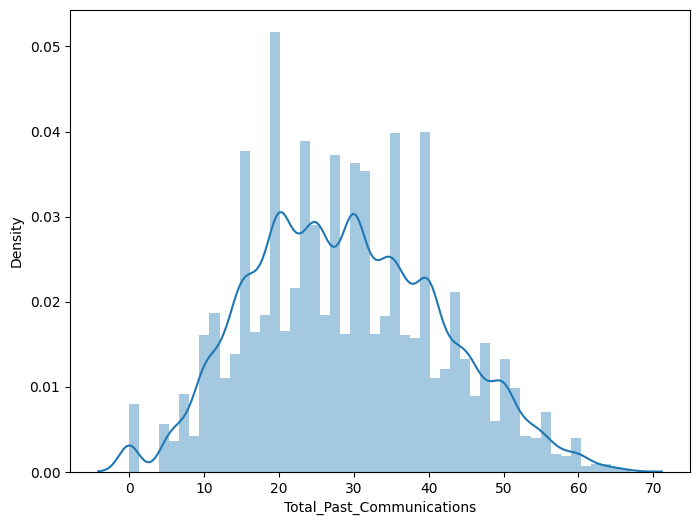

In [19]:
# Dense plot for Total_Past_Communications 
dense_plot(df,'Total_Past_Communications')

Since there is a large number of missing observation so let check their relation with some important features 

<Axes: xlabel='Total_Past_Communications', ylabel='Email_Source_Type'>

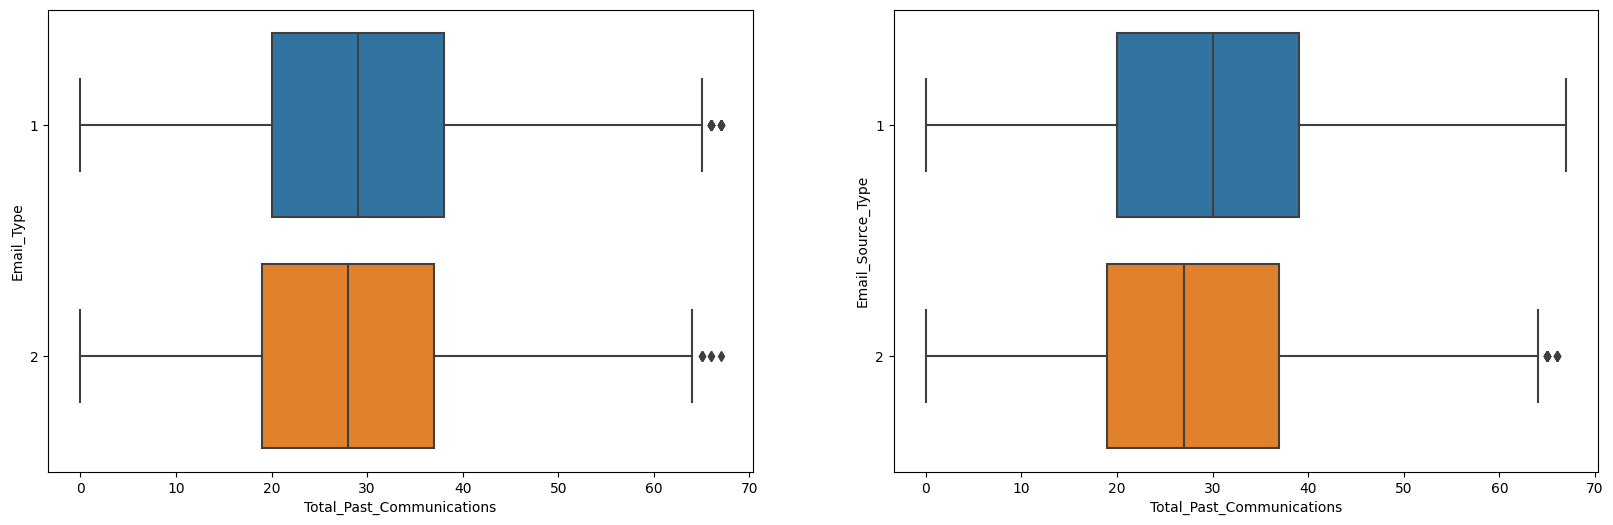

In [20]:
# Box plot to visualize Total_Past_Communications with Email_Type and Email_Source_Type
fig,axes= plt.subplots(1,2, figsize=(20,6))
sns.boxplot(ax=axes[0],data=df,x='Total_Past_Communications',y='Email_Type',orient='h')
sns.boxplot(ax=axes[1],data=df,x='Total_Past_Communications',y='Email_Source_Type',orient='h')

Number of outliers : 27
Outlier Percentage : 0.04%


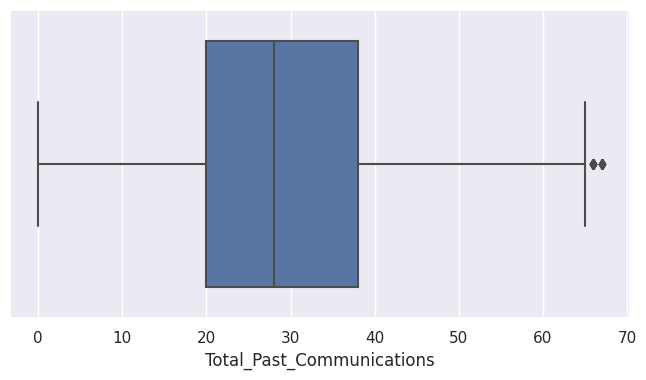

In [21]:
# lets get a box to know the outliers Total_Past_Communications and to get the count and percentage of the box plot 

out_count,out_percent=out_count_percen(df,'Total_Past_Communications')
print(f'Number of outliers : {out_count}')
print(f'Outlier Percentage : {out_percent}%')
box_plot(df,'Total_Past_Communications')

As there is very less number of outliers we can impute them with mean

In [22]:
# Replacing the missing values with mean
df.Total_Past_Communications.fillna(value=df.Total_Past_Communications.mean(),inplace=True)

Lets create a dense plot to know the distribution of Total_Links

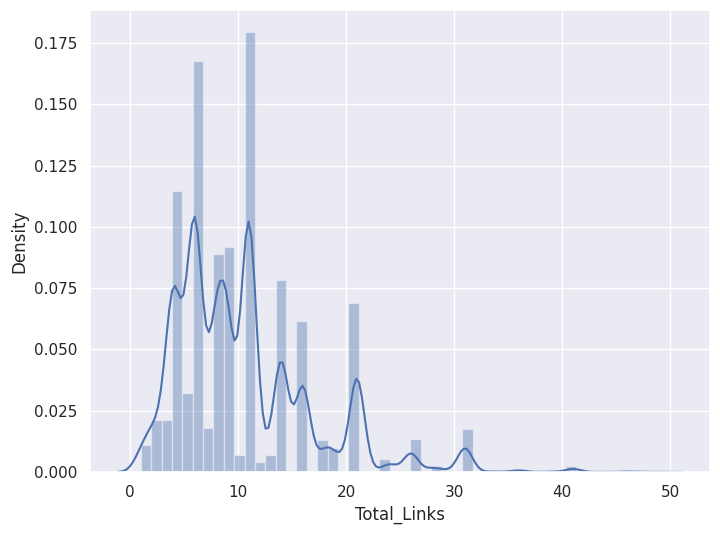

In [23]:
# Dense plot for Total_Links
dense_plot(df,'Total_Links')


Total_Links feature is positively skewed and has a very less number of missing 

Lets create a box to clearly understand the outliers

Number of outliers : 1608
Outlier Percentage : 2.35%


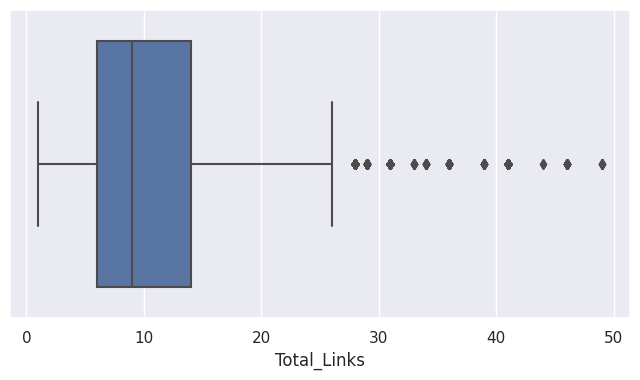

In [24]:
out_count,out_percent=out_count_percen(df,'Total_Links')
print(f'Number of outliers : {out_count}')
print(f'Outlier Percentage : {out_percent}%')
box_plot(df,'Total_Links')

We could see there is a notable number of outliers, So we impute the missing value with mode

In [25]:
# Filling the missing values with mode of Total_Links
df.Total_Links.fillna(value=df.Total_Links.mode()[0],inplace= True)

Lets create a dense plot to know the distribution of Total_Images

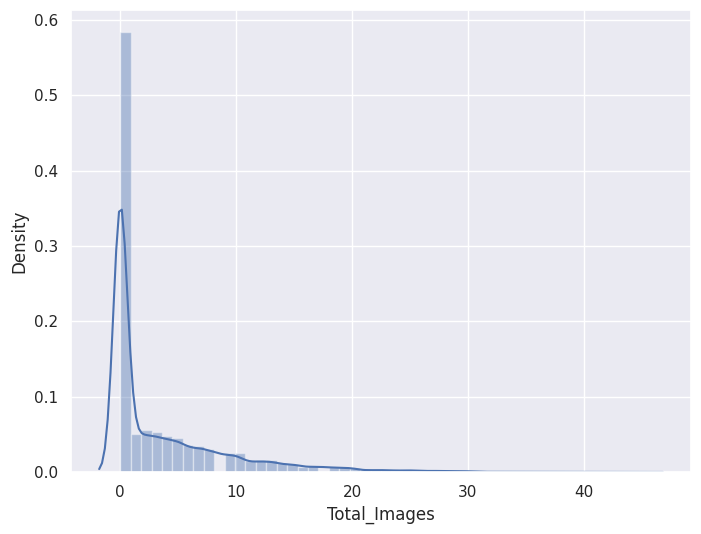

In [26]:
# Dense plot for Total_Images
dense_plot(df,'Total_Images')

Total_Images is positively skewed and has a less number of missing values 


Lets create a box plot to know more about the outliers 

Number of outliers : 5585
Outlier Percentage : 8.17%


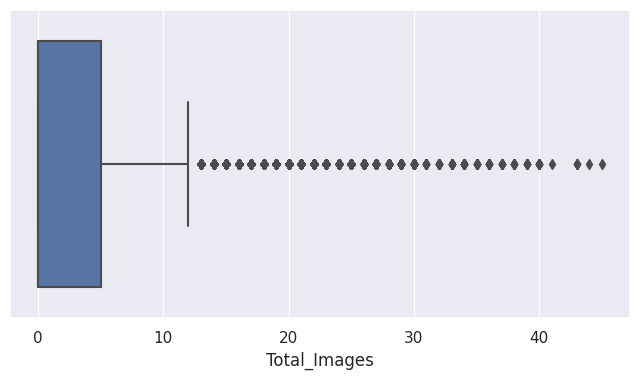

In [27]:
out_count,out_percent=out_count_percen(df,'Total_Images')
print(f'Number of outliers : {out_count}')
print(f'Outlier Percentage : {out_percent}%')
box_plot(df,'Total_Images')

As there is large values of outlies in Total_Images, So lets impute the missing values with mode 

In [28]:
# Filling the missing values with mode of Total_Images
df.Total_Images.fillna(value=df.Total_Images.mode()[0],inplace= True)

In [29]:
# Now lets see the number of number and percentage of missing values in the dataframe 
NA_count_percentage(df)


Customer_Location : 11595, 16.96%


## Data Type Conversion

In [30]:
# Data types of all feature in the dataframe 
df.dtypes

Email_ID                      object
Email_Type                     int64
Subject_Hotness_Score        float64
Email_Source_Type              int64
Customer_Location             object
Email_Campaign_Type            int64
Total_Past_Communications    float64
Time_Email_sent_Category       int64
Word_Count                     int64
Total_Links                  float64
Total_Images                 float64
Email_Status                   int64
dtype: object

Total_Past_Communications,Total_Links,Total_Images are of float data types so lets convert them to integer data types

In [31]:
df=df.astype({"Total_Past_Communications":int,'Total_Links' : int , 'Total_Images' : int})

# Exploratory Data Analysis


First and foremost lets check whether the data set is balanced or not

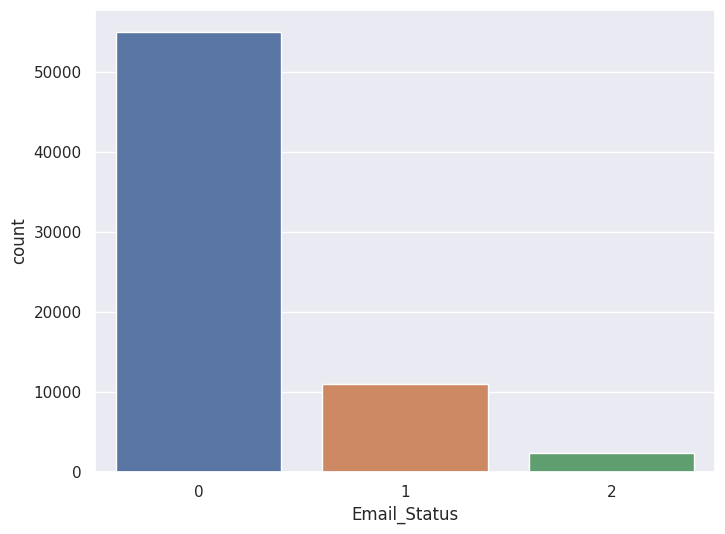

In [32]:
# Bar plot to show the count of each category in Email_Status
count_plot(df,'Email_Status')

Email_Status 0 has a very high obervations compared to other Email_Status 1 , 2 combined.

From this we come to know that the data set is highly imbalanced 

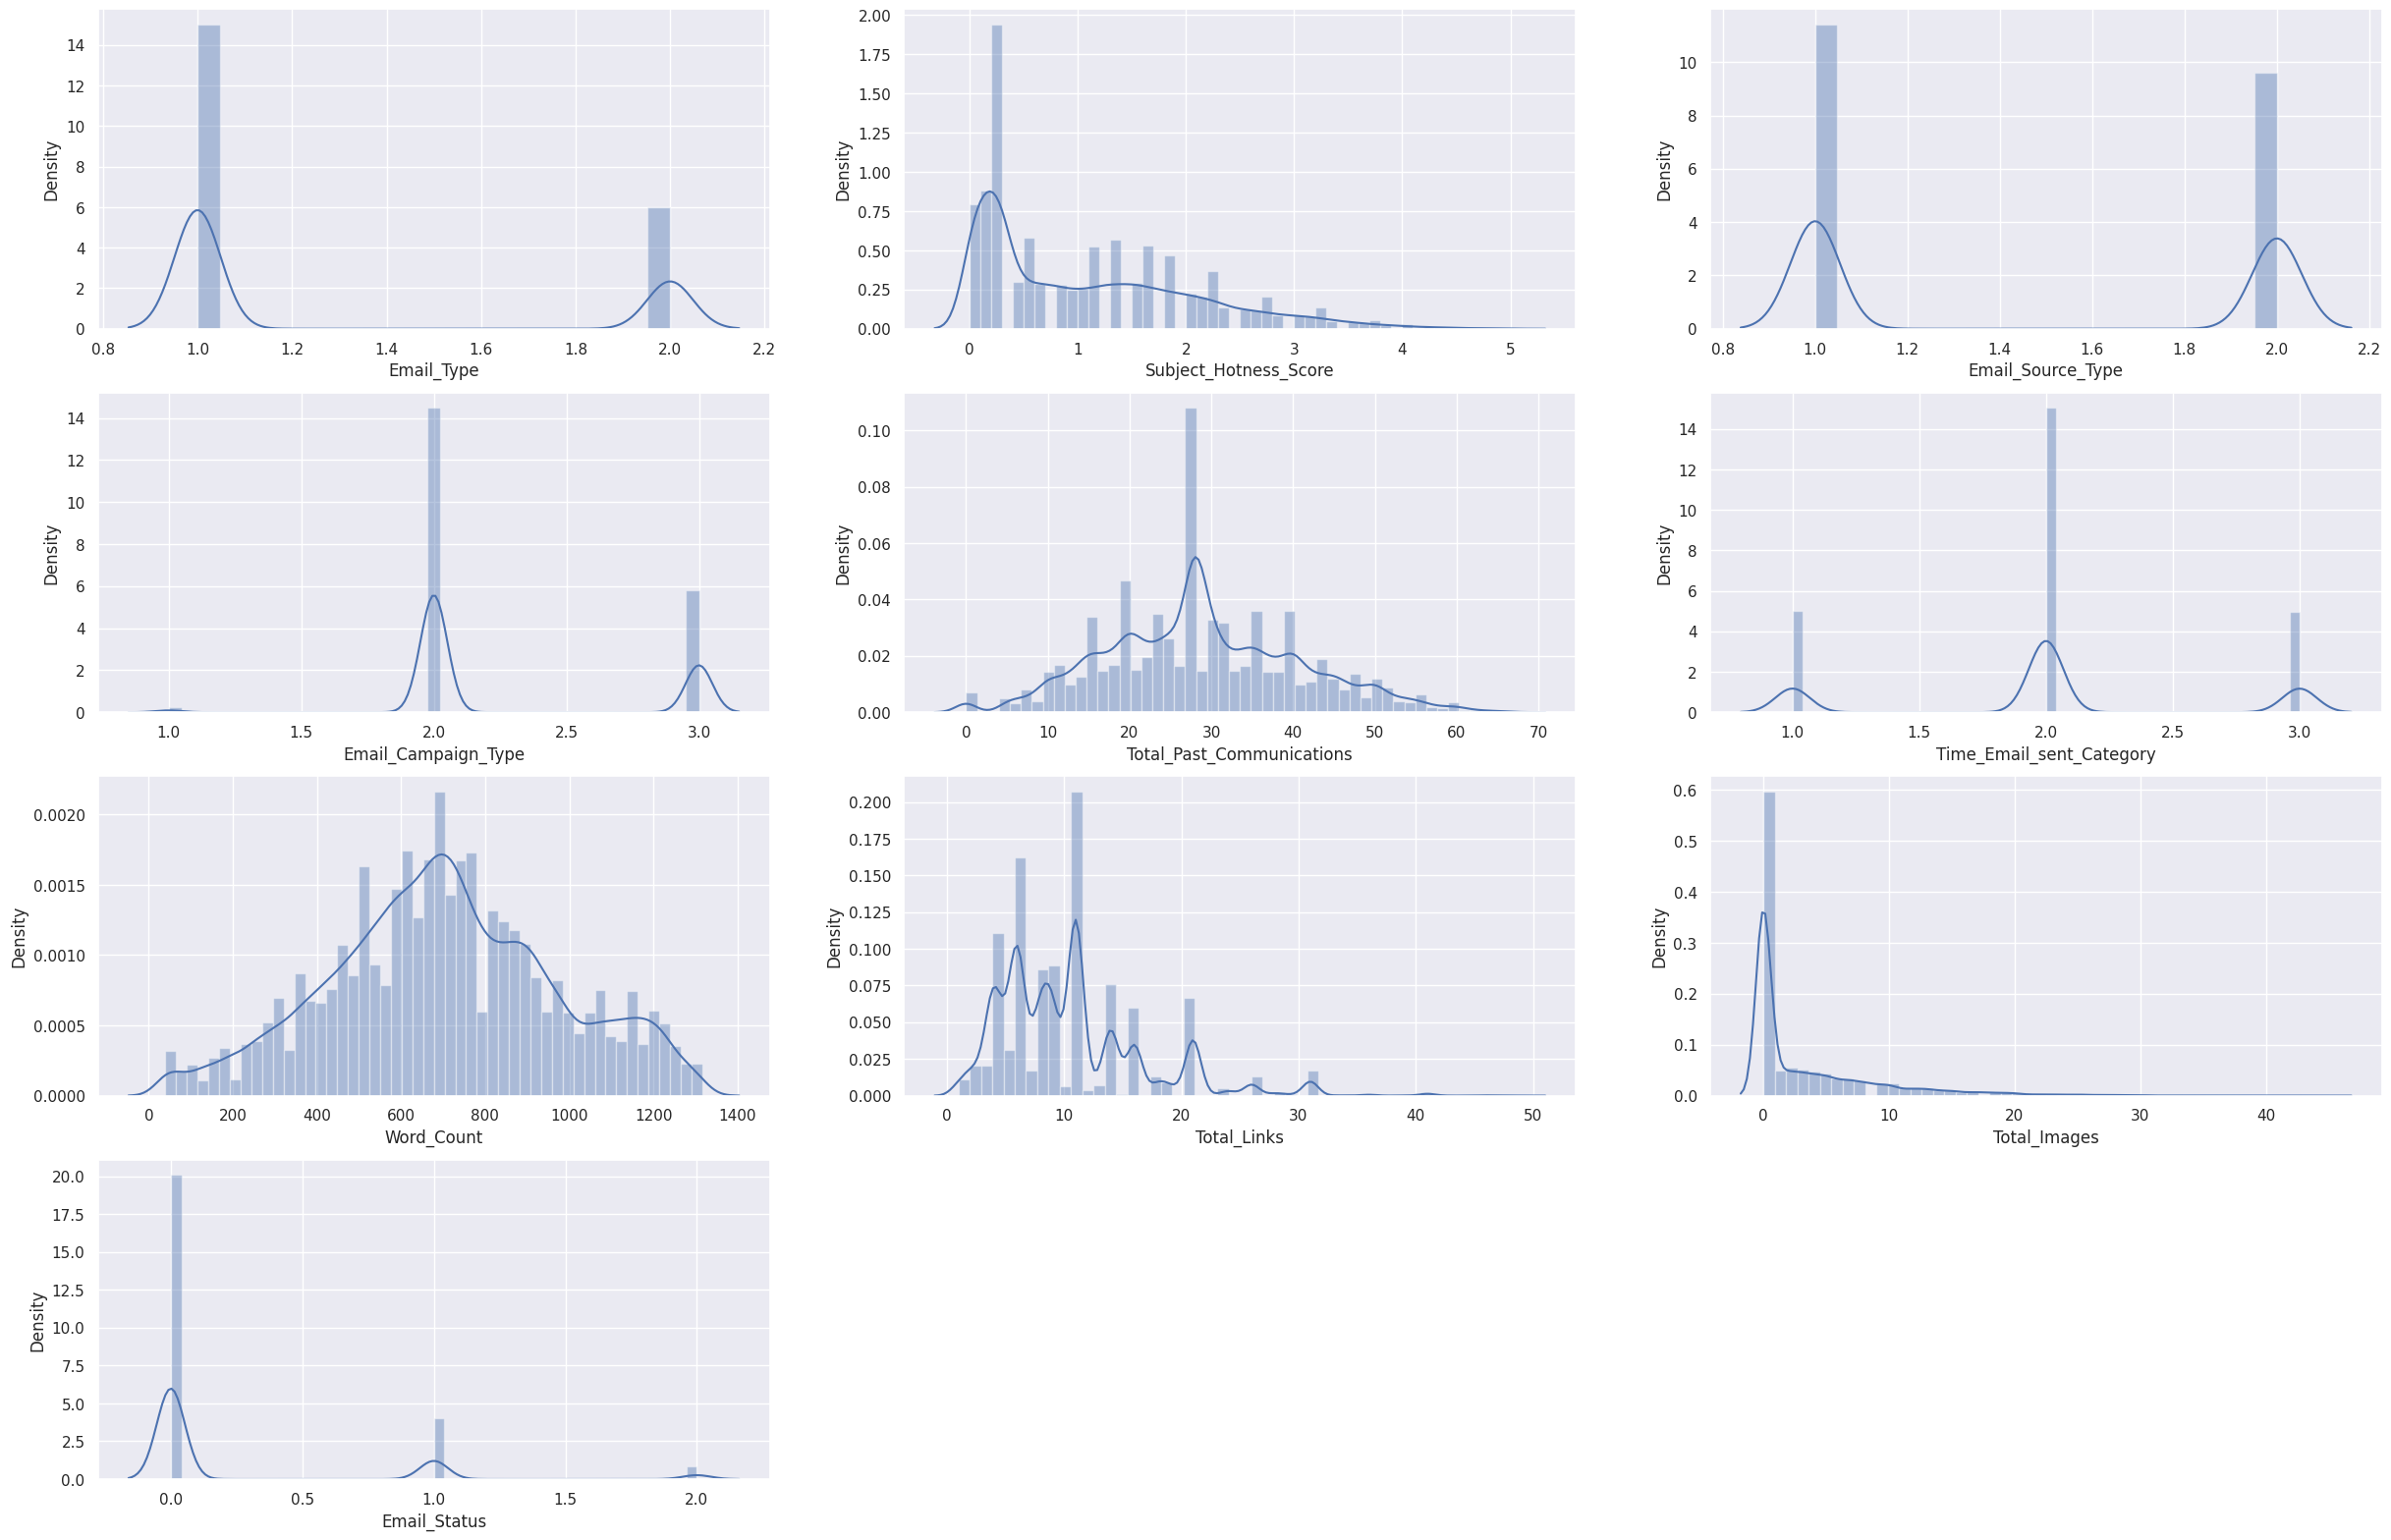

In [33]:
# Distribution plot for all features 
dist_plot_all_features(df)

Fetures like Subject_Hotness_Score, Total_Links and Total_Images are positively skewed and Total_Past_Communications and Word_Count are almost normally distributed. Rest of the features are categorical.

Lets check the impact of categorical on Email_Status  

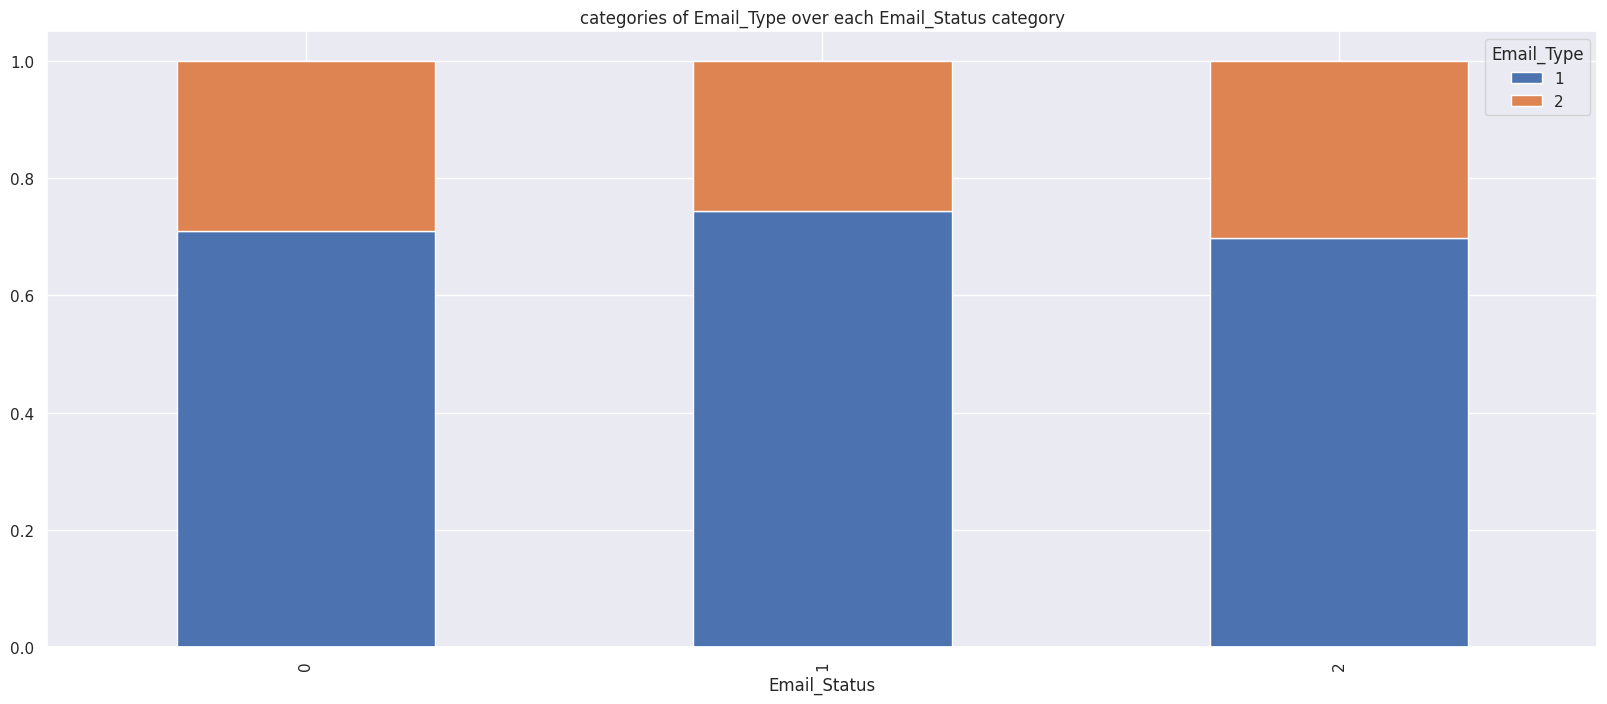

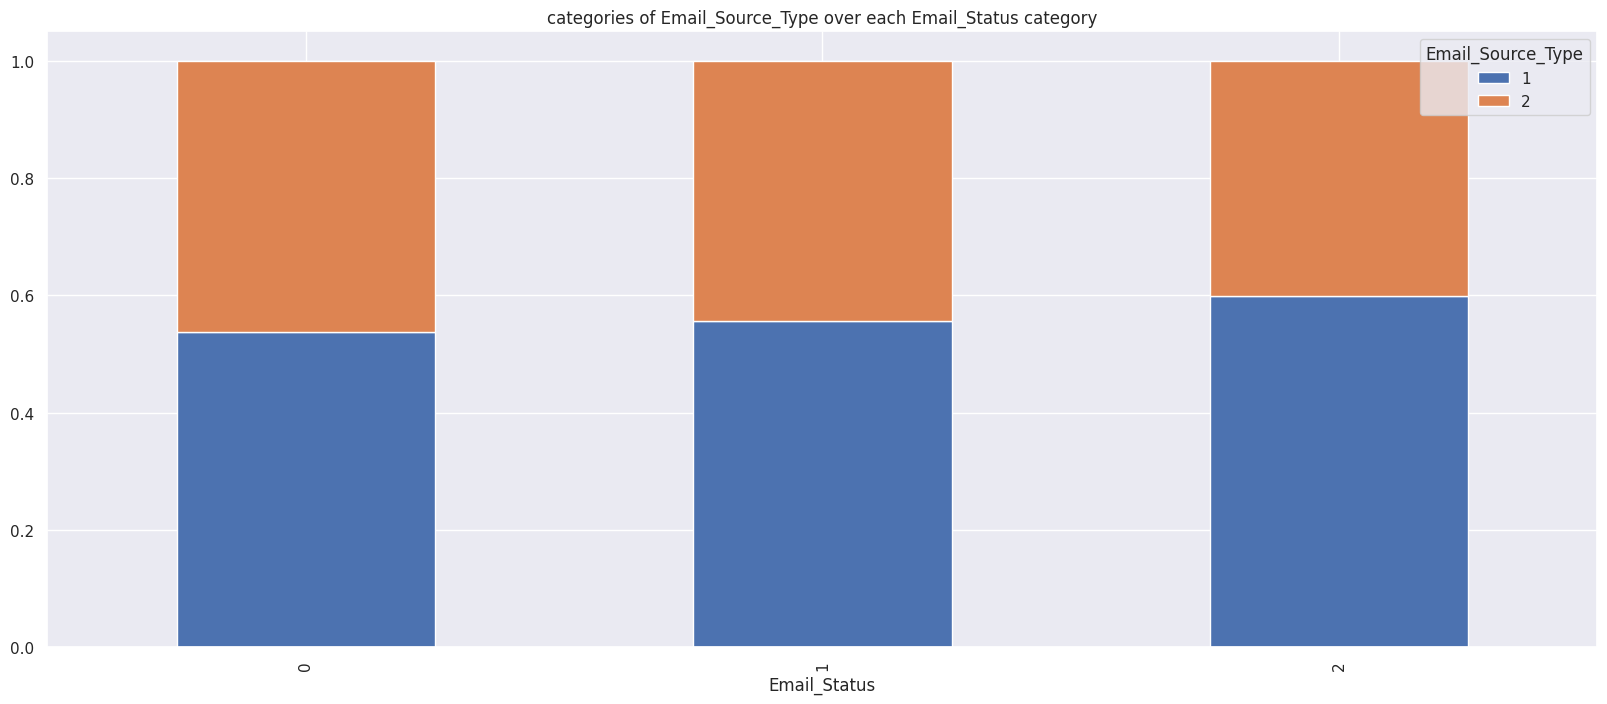

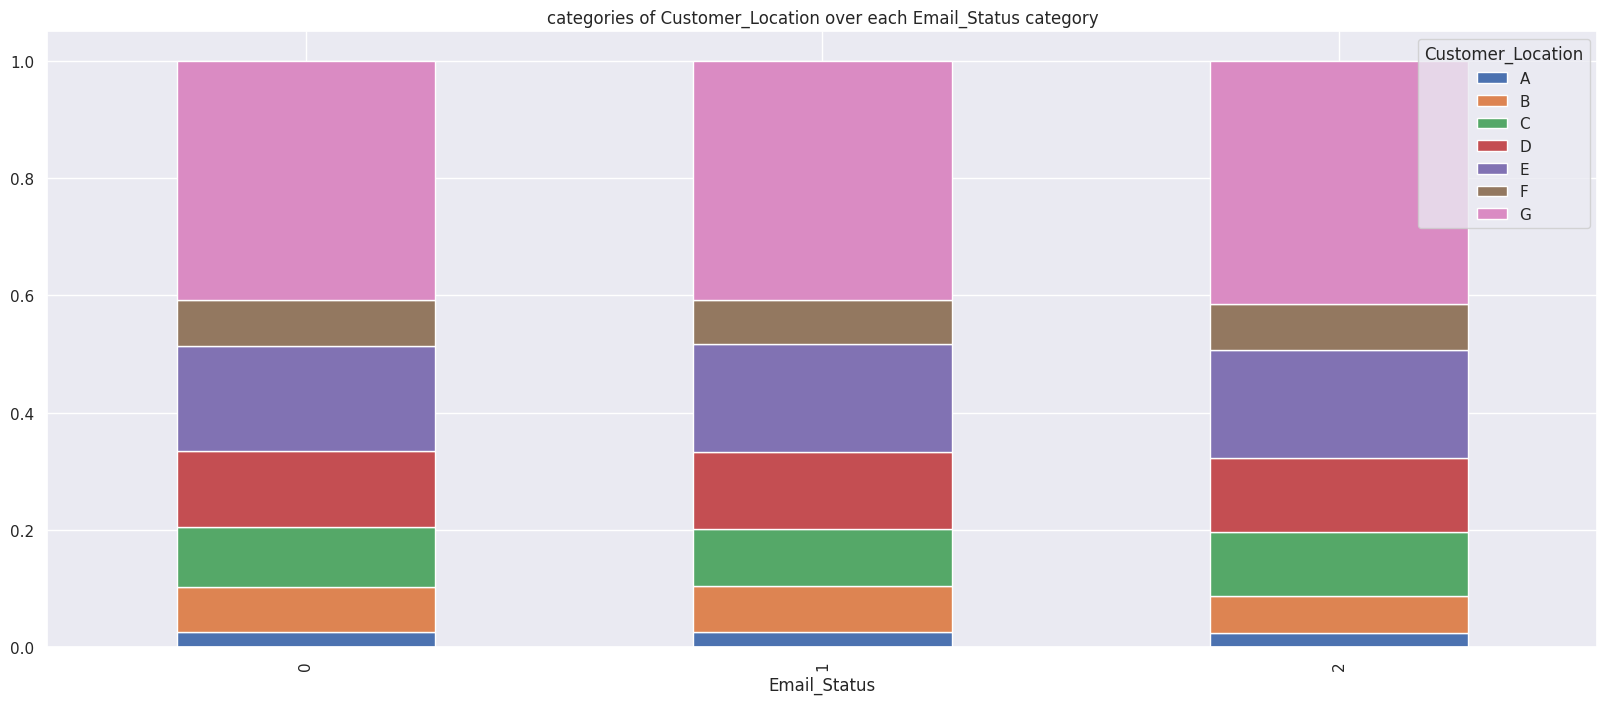

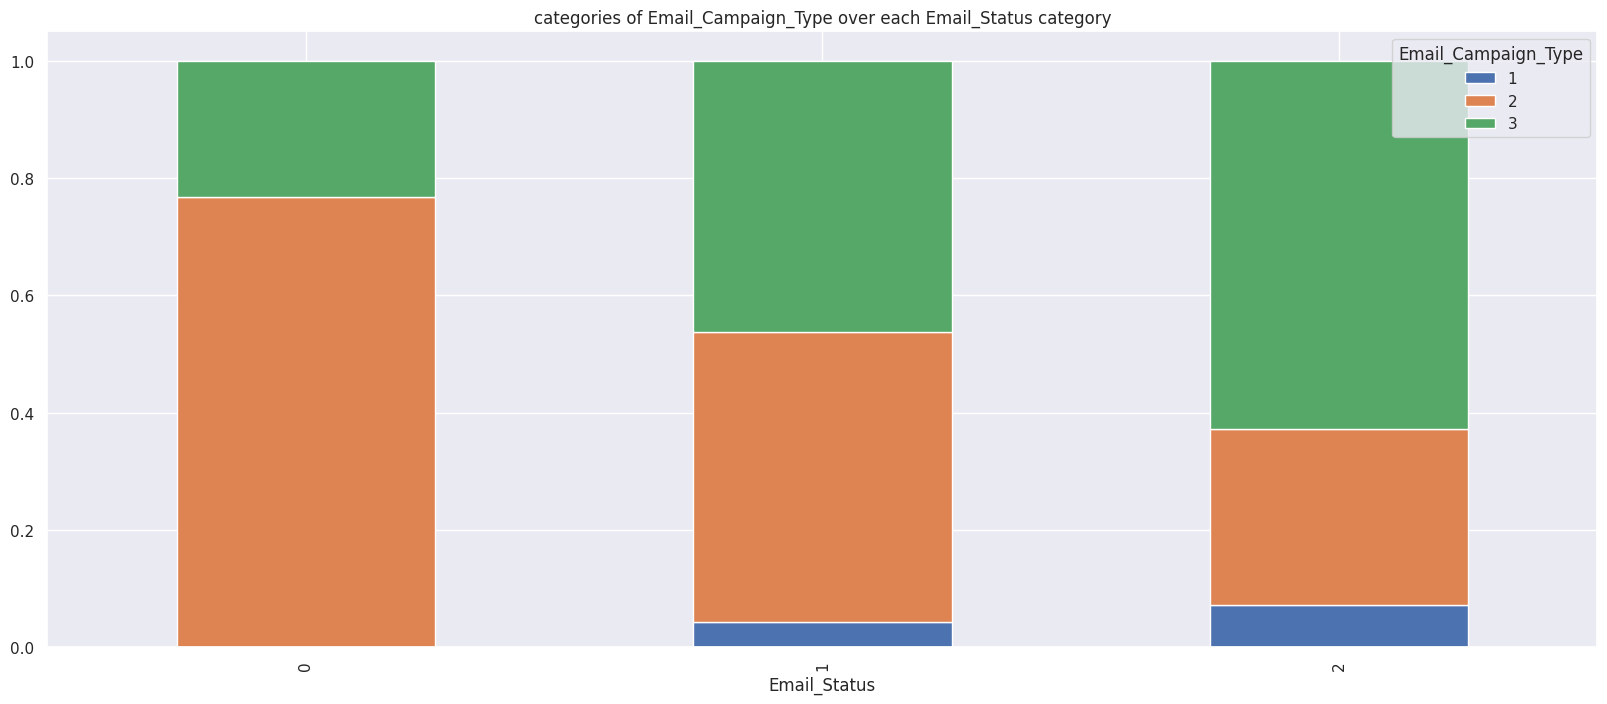

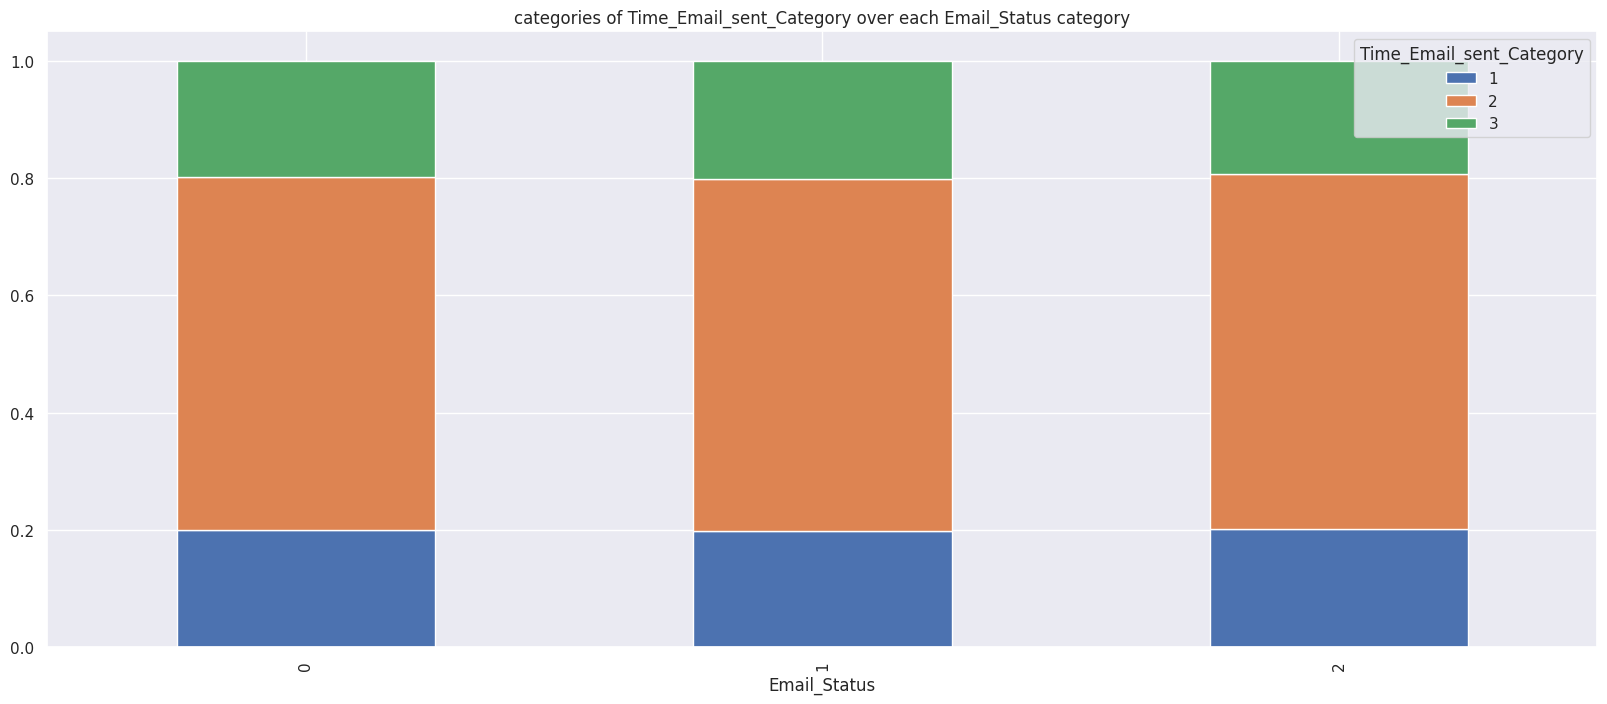

In [34]:
# Creating stacked bar graph for all categorical feature
cat_features=['Email_Type', 'Email_Source_Type', 'Customer_Location', 
                        'Email_Campaign_Type', 'Time_Email_sent_Category']
for x in cat_features:
  stacked_plot(df,'Email_Status',x)

Nearly all categorical features have a same distribution over Email_status except the Email_Campaign_Type feature which is not distributed like other features and has high impact on Email_status(target feature)



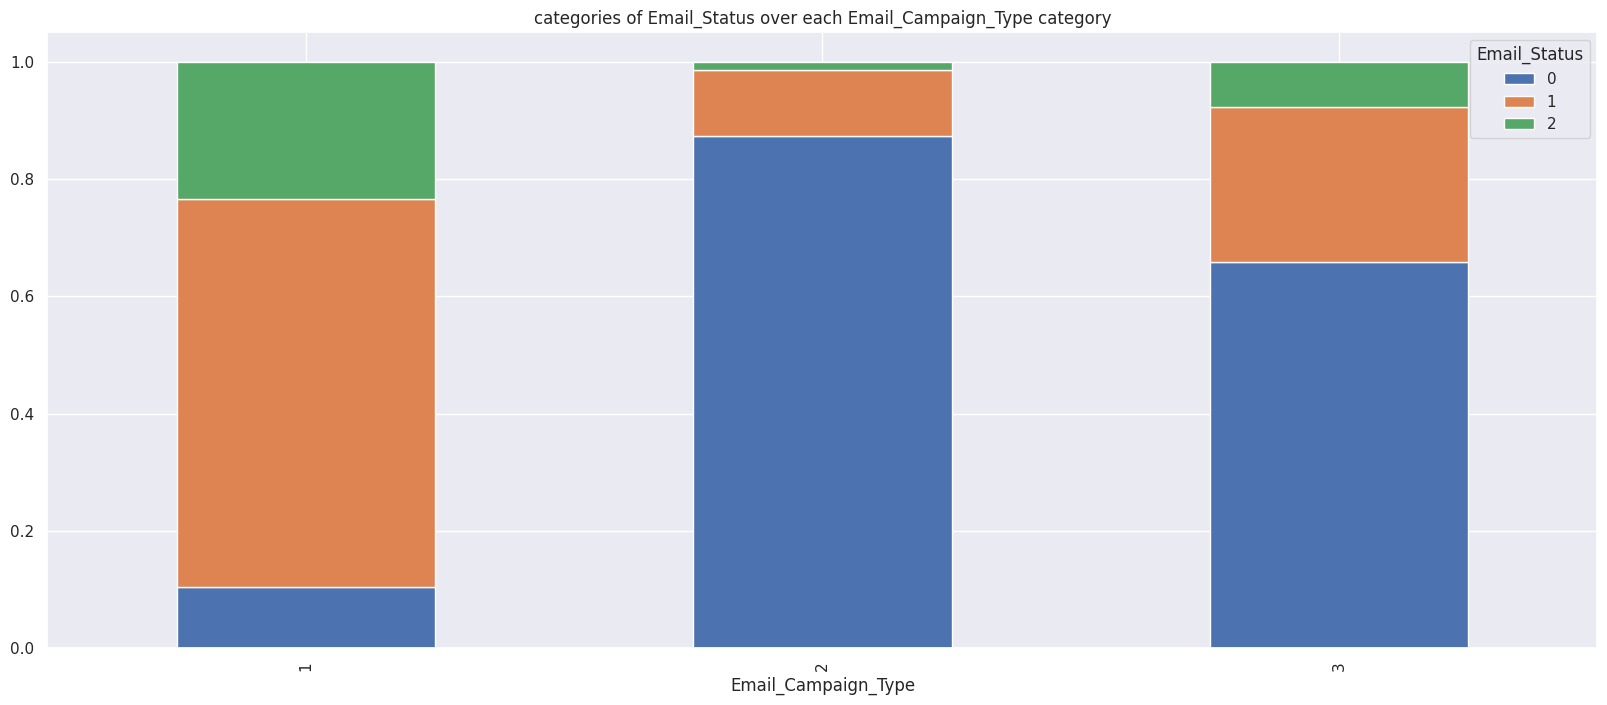

In [35]:
# Lets create a stacked bar plot to see the impact of Email_Campaign_Type over Email_status
stacked_plot(df,'Email_Campaign_Type','Email_Status')

when there is Email_campaing_type is 1 there is nearly 60 to 65% of getting read and 20 to 25% chance of getting acknowledged

In [36]:
num_features = ['Subject_Hotness_Score', 'Total_Past_Communications', 
                      'Word_Count', 'Total_Links', 'Total_Images']

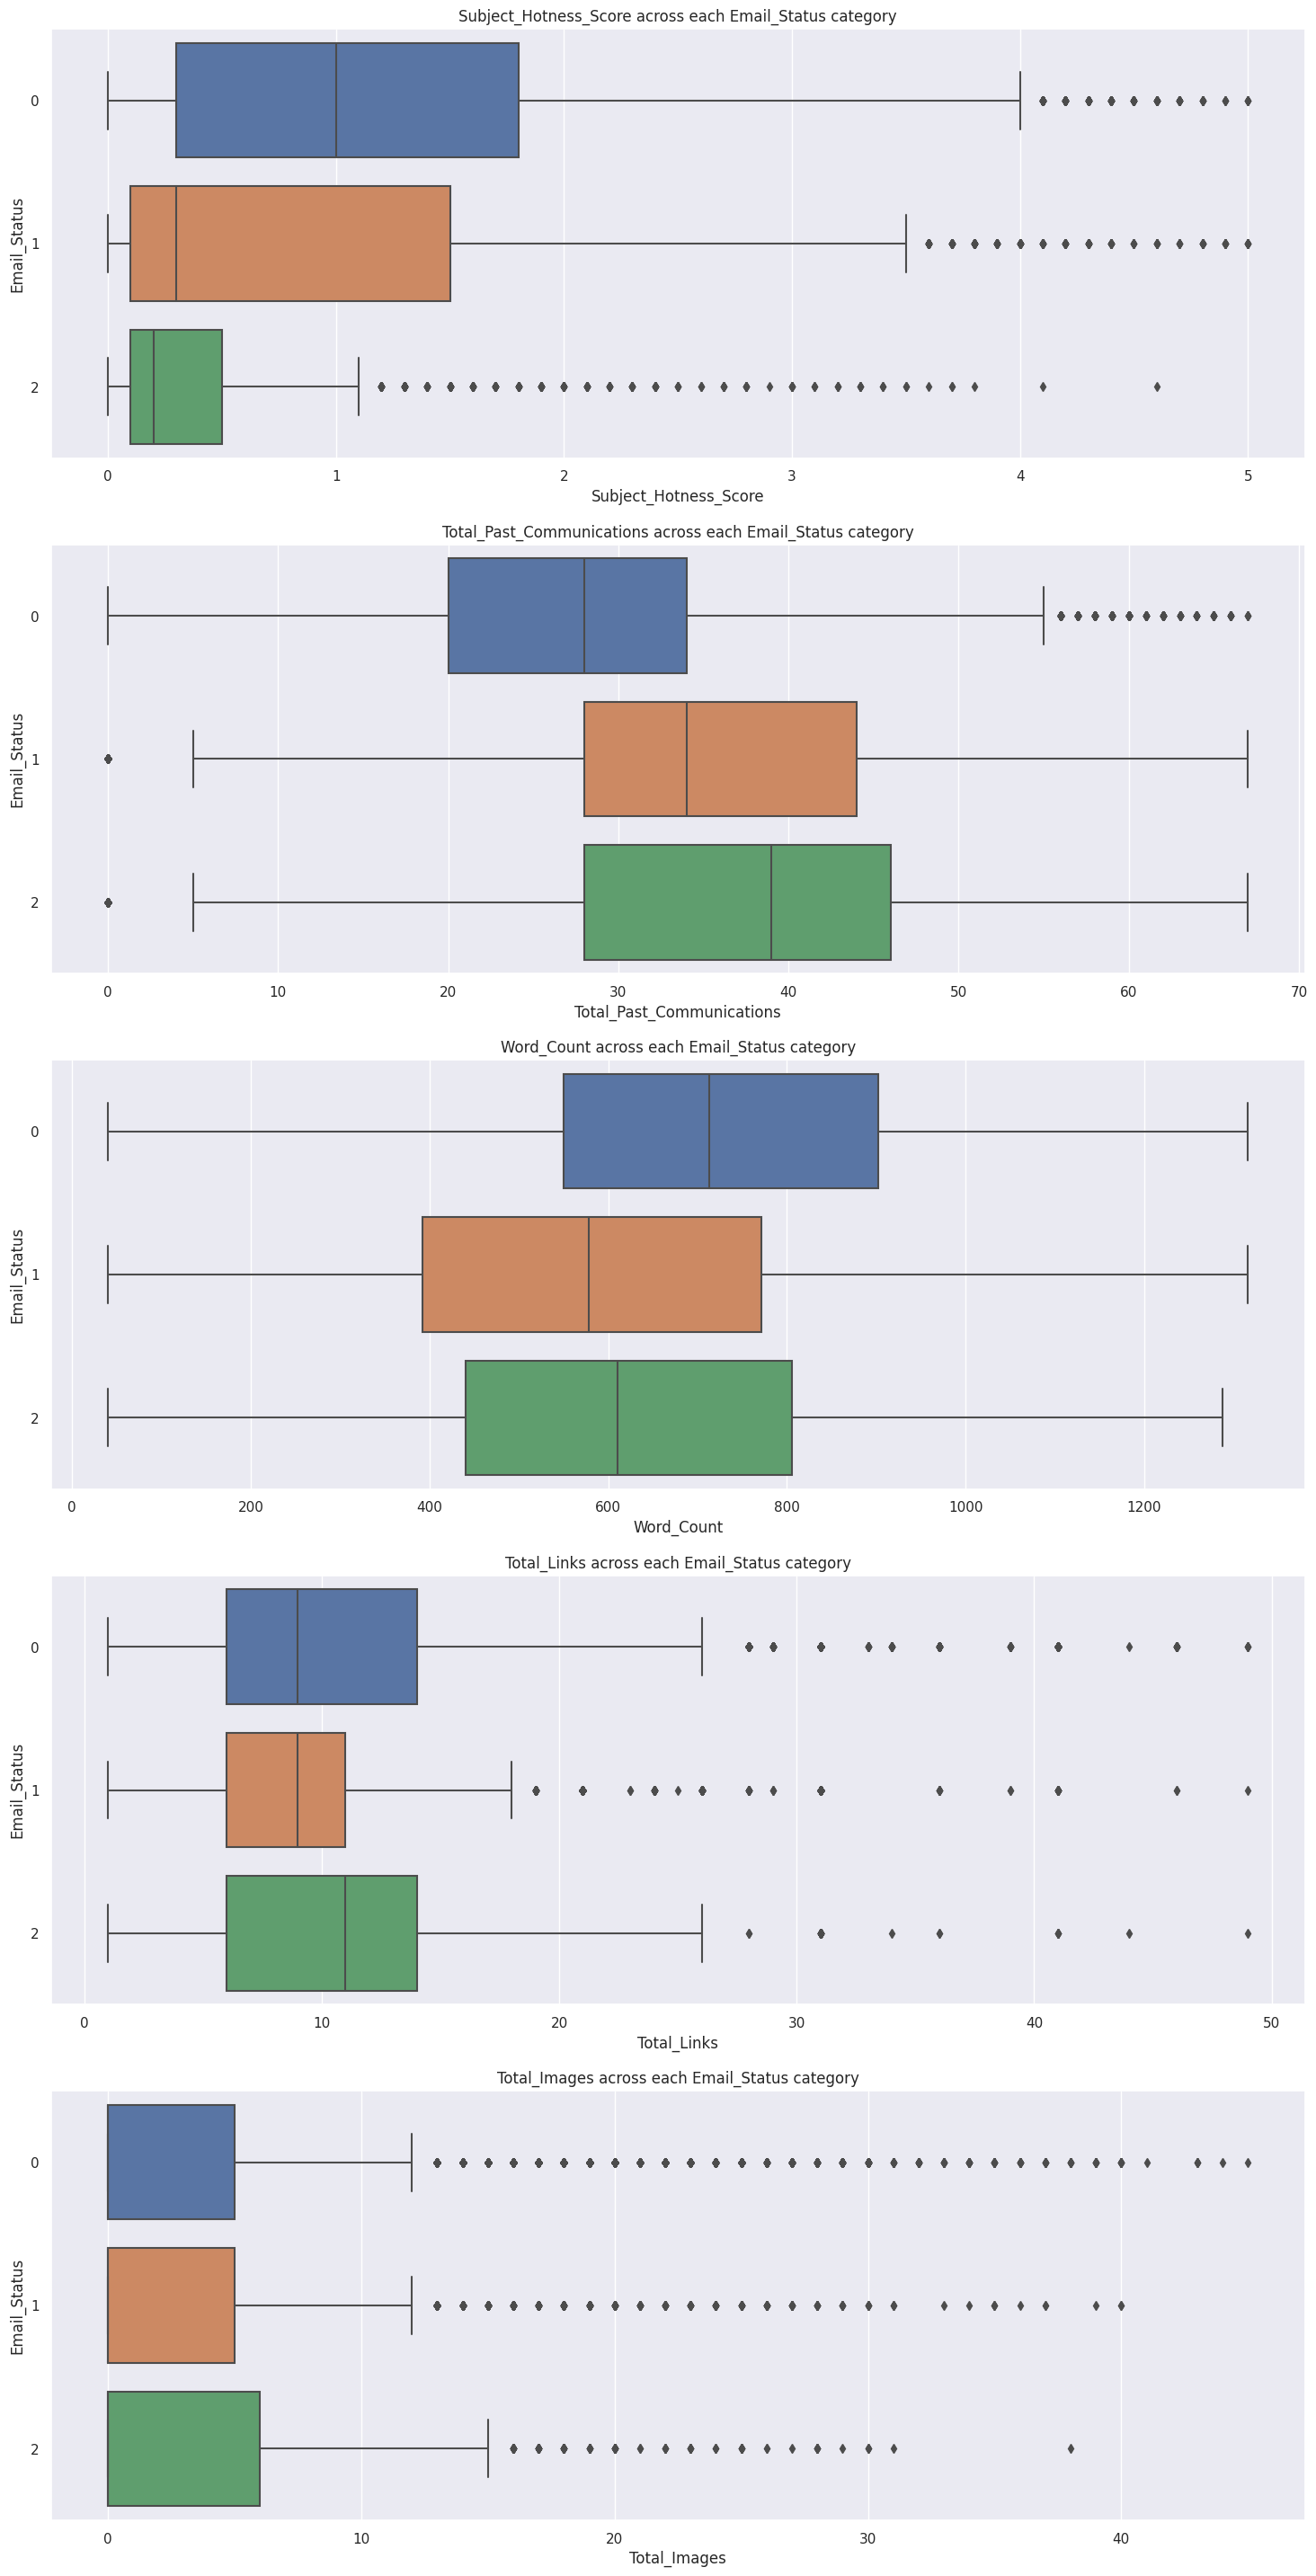

In [37]:
# Creating a box plot for numerical features in each category of Email_Status
fig, axes = plt.subplots(5, 1, figsize=(18, 36))

for row, feature in enumerate(num_features):
  sns.boxplot(ax=axes[row],data=df,x=feature,y='Email_Status',orient='h')
  axes[row].set_title(f'{feature} across each Email_Status category')

If the Subject_Hotness_Score is less than 5 the chance of mail getting acknowleged or read is high.

The probability of mail getting acknowledged decreases as Subject_Hotness_Score increases.

When the Total_Past_Communications is greater than 25 the chance of getting acknowleged or read is high.

The propotion of mail getting acknowleged or read is directly protiontional to the number of Total_Past_Communications

When Word_Count in a mail increses the chance of mail getting read or acknowledged decreses 

When the Word_Count is between 400 to 800 the chance of mail getting read or acknowledged is high

The Total_Links and Total_Images have similar distribution across each Email_Status category but read mails have slightly less variance than others, and acknowledged mails have slightly more variance than others respectively.

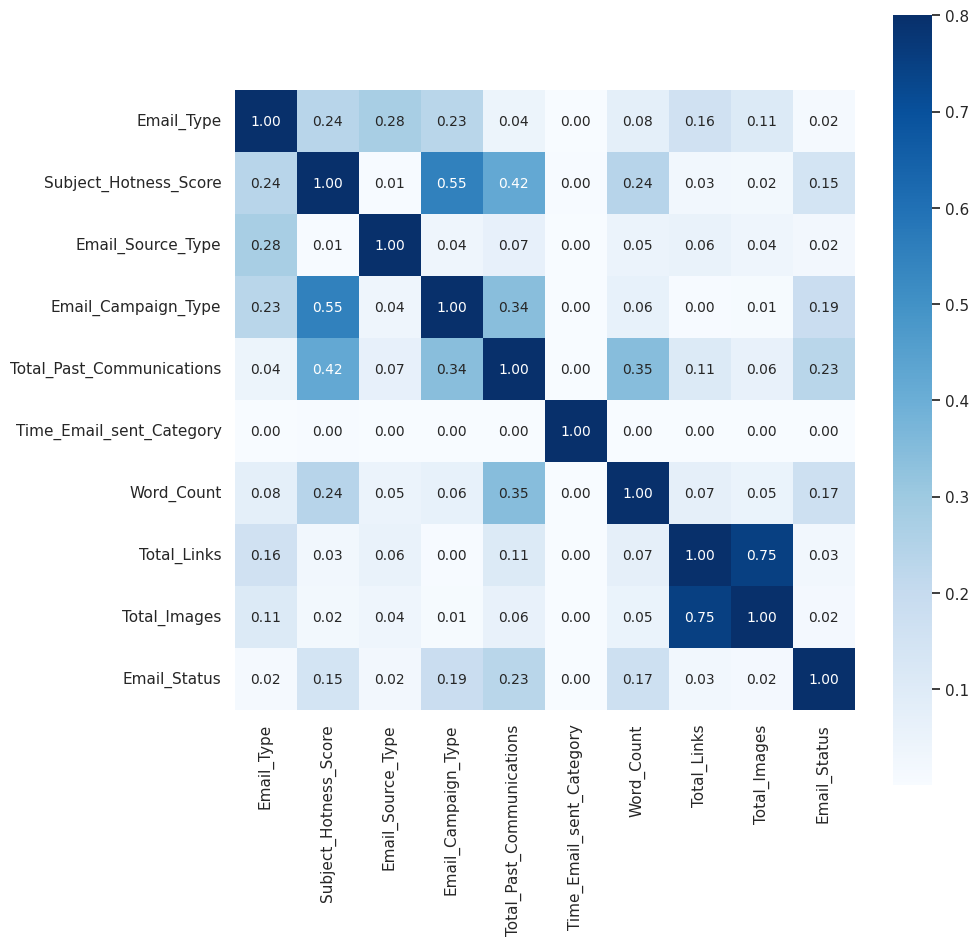

In [38]:
# Creating Co relation Heatmap for all the features in the dataframe 
Heatmap=df.corr().abs()
fig, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(Heatmap, annot = True, fmt='.2f', annot_kws={'size': 10},  vmax=.8, square=True, cmap='Blues');

The only feature that has no co-relation with Email_Status and all other independent features is Time_Email_sent_Category

Multicollinearity is observed between Subject_Hotness_Score, Email_Campaign_Type & Total_Past_Communications and Total_Links & Total_Images.

# Feature Engineering

In [39]:
# Getting the overview of the Dataset
df.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33,1,440,8,0,0
1,EMA00081000045360,2,2.1,1,NaN,2,15,2,504,5,0,0
2,EMA00081000066290,2,0.1,1,B,3,36,2,962,5,0,1
3,EMA00081000076560,1,3.0,2,E,2,25,2,610,16,0,0
4,EMA00081000109720,1,0.0,2,C,3,18,2,947,4,0,0


## Feature Selection

In [40]:
# Removing Email_ID from the data as it has no impact on our target variable 
df.drop('Email_ID', axis=1, inplace=True)

Removing Customer_Location as it has many missing values which cannot be imputed with other values,also location does not make any impact on the target variable, the three categories in the target variable has the same probability

In [41]:
# Dropping Customer_Location
df.drop('Customer_Location', axis=1, inplace=True)

Time_Email_sent_Category has no relationship with any features which is established in the EDA section, so lets drop that

In [42]:
# Dropping Time_Email_sent_Category
df.drop('Time_Email_sent_Category', axis=1, inplace=True)

## Handling Multicolinearity

In [43]:
# Calculating VIF for all Continuous features 
continous_features = df[['Subject_Hotness_Score', 'Total_Past_Communications', 'Word_Count', 'Total_Links', 'Total_Images']]
vif=pd.DataFrame()
vif['Feature']=continous_features.columns
vif['VIF']=[variance_inflation_factor(continous_features.values,i) for i in range(len(continous_features.columns))]

vif

,Feature,VIF
0,Subject_Hotness_Score,1.805705
1,Total_Past_Communications,3.927452
2,Word_Count,4.061685
3,Total_Links,8.690925
4,Total_Images,3.171417


We could see that Total_Links is the only continuous feature that has a VIF score more than 5. 

But dropping Total_Links is possible as it is a important feature which we established from our EDA section

Also we have also noticed a Total_Links and Total_Images had a good corelation

So lets combine them to form a single feature by adding two features

In [44]:
# Adding Total_Links and Total_Images to create a new feature Total_image_link
df['Total_image_link']=df['Total_Images']+df['Total_Links']
df.drop(['Total_Images','Total_Links'],axis=1,inplace=True)

In [45]:
# Lets check the VIF for all continuous feature another time as we have added a new feature to the dataset 
continous_features = df[['Subject_Hotness_Score', 'Total_Past_Communications', 'Word_Count', 'Total_image_link']]
vif=pd.DataFrame()
vif['Feature']=continous_features.columns
vif['VIF']=[variance_inflation_factor(continous_features.values,i) for i in range(len(continous_features.columns))]

vif

,Feature,VIF
0,Subject_Hotness_Score,1.734297
1,Total_Past_Communications,3.420644
2,Word_Count,3.681663
3,Total_image_link,2.629101


*Now all the continuous feature is having a VIF score below 5*

## Outlier Handling

**Subject_Hotness_Score**

Number of outliers : 247
Outlier Percentage : 0.36%


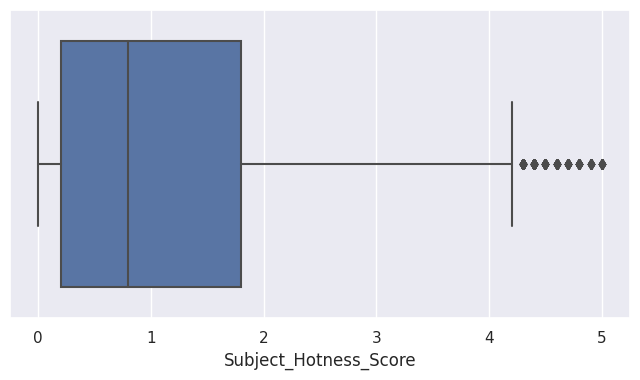

In [46]:
# Generating a Box Plot, Outlier count and Outlier percentage for Subject_Hotness_Score
out_count,out_percent=out_count_percen(df,'Subject_Hotness_Score')
print(f'Number of outliers : {out_count}')
print(f'Outlier Percentage : {out_percent}%')
box_plot(df,'Subject_Hotness_Score')

As the outlier percentage is very less lets remove them

In [47]:
# Outlier Removal
upper,lower= up_low_bound(df,'Subject_Hotness_Score')
df=df[(df['Subject_Hotness_Score']>lower) & (df['Subject_Hotness_Score']<(upper-0.2))]

**Total_Past_Communications**

Number of outliers : 136
Outlier Percentage : 0.2%


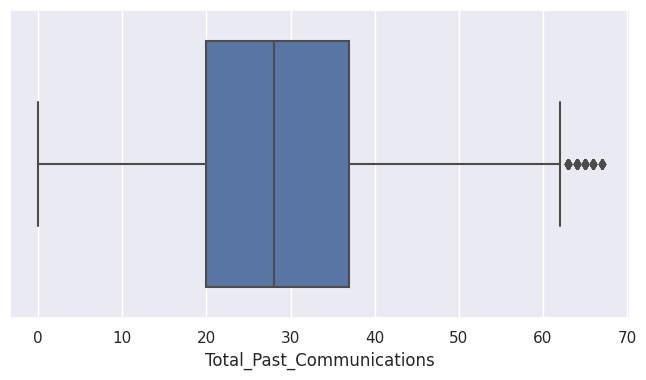

In [48]:
# Generating a Box Plot, Outlier count and Outlier percentage for Total_Past_Communications
out_count,out_percent=out_count_percen(df,'Total_Past_Communications')
print(f'Number of outliers : {out_count}')
print(f'Outlier Percentage : {out_percent}%')
box_plot(df,'Total_Past_Communications')

As the outlier percentage is very less lets remove them

In [49]:
# Outlier Removal
upper,lower= up_low_bound(df,'Total_Past_Communications')
df=df[(df['Total_Past_Communications']>lower) & (df['Total_Past_Communications']<upper)]

Number of outliers : 0
Outlier Percentage : 0.0%


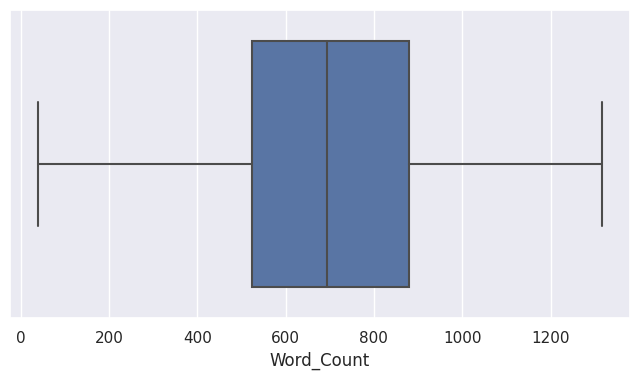

In [50]:
# Generating a Box Plot, Outlier count and Outlier percentage for Word_Count
out_count,out_percent=out_count_percen(df,'Word_Count')
print(f'Number of outliers : {out_count}')
print(f'Outlier Percentage : {out_percent}%')
box_plot(df,'Word_Count')

Fortunately there is no outliers in Word_Count feature

Number of outliers : 3605
Outlier Percentage : 5.33%


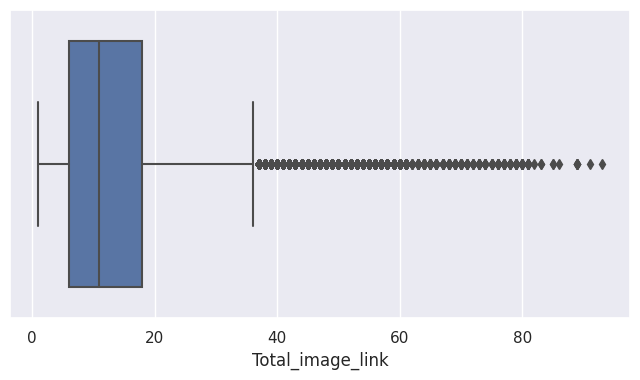

In [51]:
# Generating a Box Plot, Outlier count and Outlier percentage for Total_image_link
out_count,out_percent=out_count_percen(df,'Total_image_link')
print(f'Number of outliers : {out_count}')
print(f'Outlier Percentage : {out_percent}%')
box_plot(df,'Total_image_link')

Email Status 1 and 2 are very low in number compared to 0 so lets see their outlier percentage and count 

Number of outliers : 722
Outlier Percentage : 5.47%


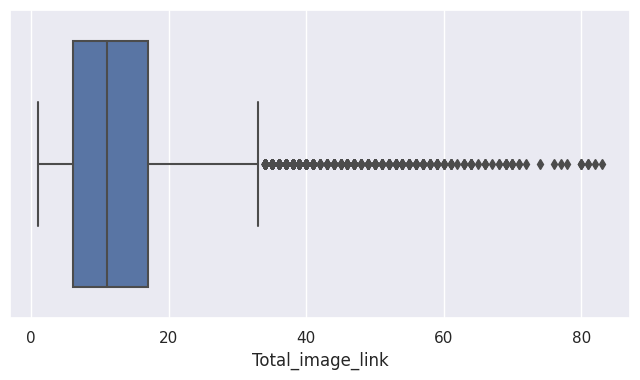

In [52]:
# Generating a Box Plot, Outlier count and Outlier percentage for Total_image_link in Email_Status 1 and 2
out_count,out_percent=out_count_percen(df[(df['Email_Status']== 1) | (df['Email_Status']== 2)],'Total_image_link' )
print(f'Number of outliers : {out_count}')
print(f'Outlier Percentage : {out_percent}%')
box_plot(df[(df['Email_Status']== 1) | (df['Email_Status']== 2)],'Total_image_link' )

As the percentage of outlier in Email Status 1 and 2 are high lets not remove 

## Feature Transformation


As the algorithms based on gradient descent better when features are close to Normal Distribution. 

Lets chek the important numerical features 

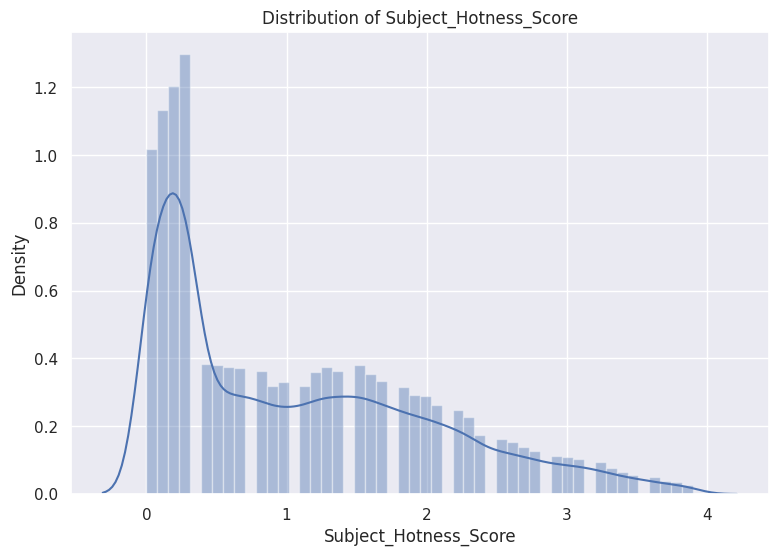

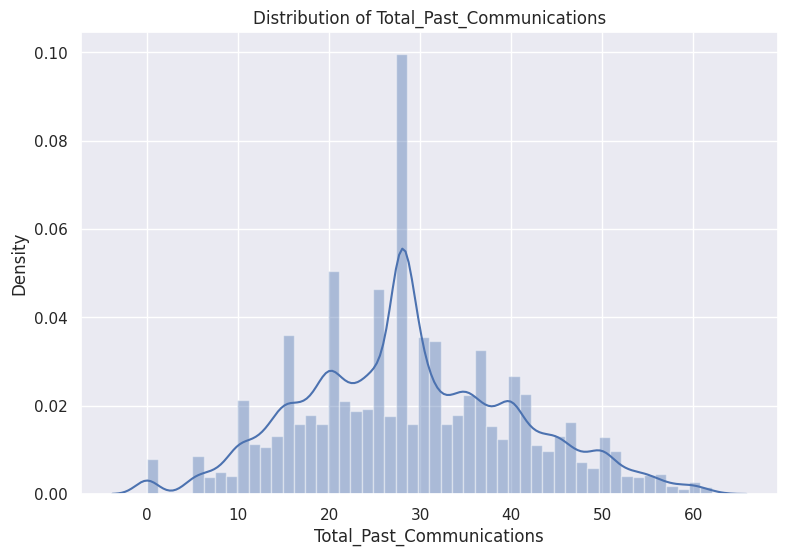

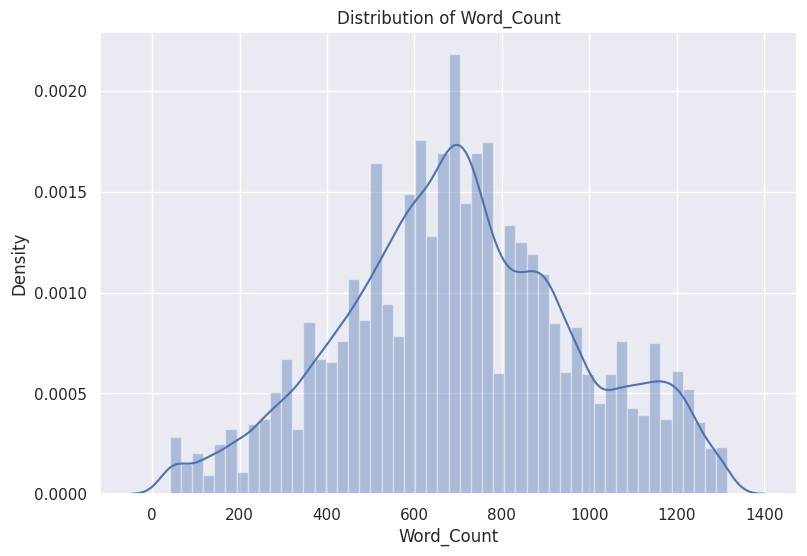

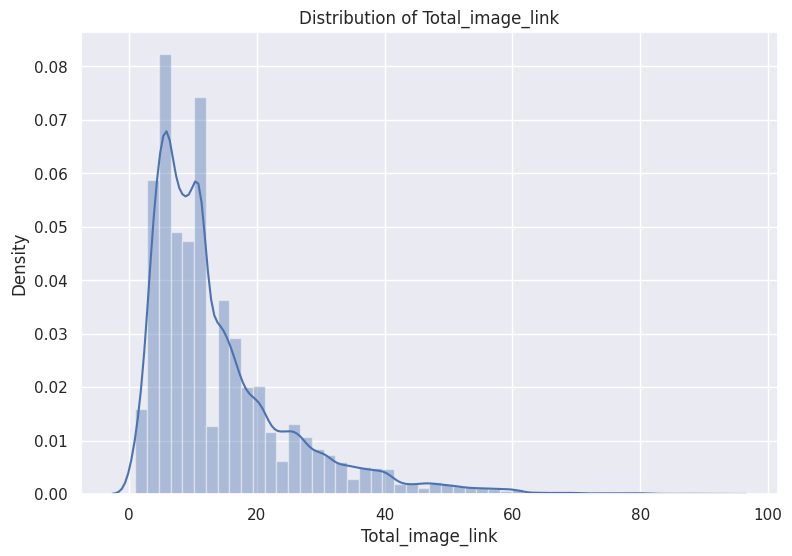

In [53]:
# Numerical Features
num_features = ['Subject_Hotness_Score', 'Total_Past_Communications', 'Word_Count', 'Total_image_link']

# generate density plot for numerical features
for i in num_features:
  plt.figure(figsize=(9,6))
  sns.distplot(df[i])
  plt.title(f'Distribution of {i}')
  plt.show()

Subject_Hotness_Score and Total_image_link are positively skewed so lets try to transform them to normal distribution

Subject_Hotness_Score has some zero values while Total_image_link do not have any zero values so lets square root transform Total_image_link and log transform Total_image_link


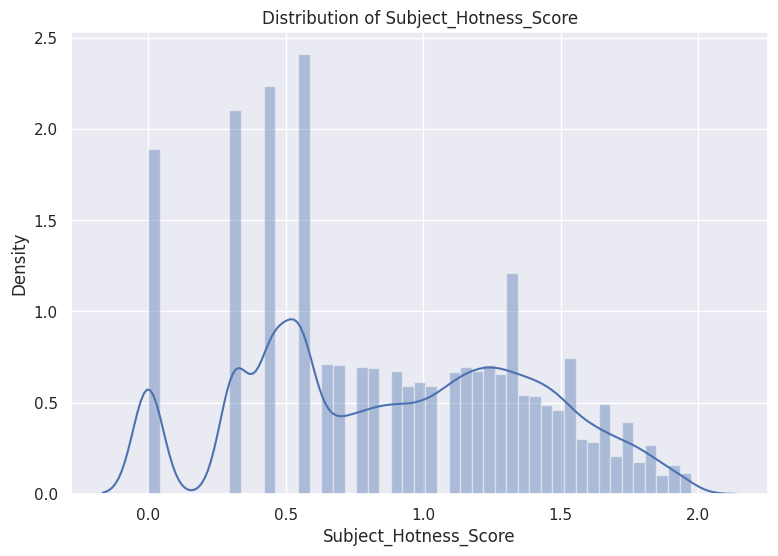

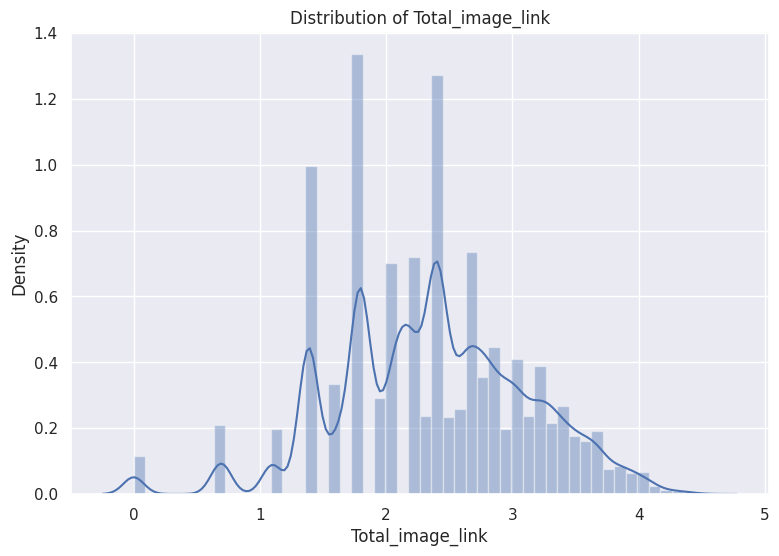

In [54]:
df['Subject_Hotness_Score']=np.sqrt(df['Subject_Hotness_Score'])
df['Total_image_link']=np.log(df['Total_image_link'])

# Features
num_features = ['Subject_Hotness_Score', 'Total_image_link']

# generate density plot for numerical features
for i in num_features:
  plt.figure(figsize=(9,6))
  sns.distplot(df[i])
  plt.title(f'Distribution of {i}')
  plt.show()

## Categorical Encoding

In [55]:
# Perfoming One Hot Encoding for categorical features 
categorical_features = ['Email_Type', 'Email_Source_Type', 'Email_Campaign_Type']
ohe = OneHotEncoder(sparse=False, dtype=int)
ohe.fit(df[categorical_features])
encoded_features = list(ohe.get_feature_names_out(categorical_features)) 
df[encoded_features] = ohe.transform(df[categorical_features])
df.drop(categorical_features,axis=1,inplace=True)

In [56]:
df

,Subject_Hotness_Score,Total_Past_Communications,Word_Count,Email_Status,Total_image_link,Email_Type_1,Email_Type_2,Email_Source_Type_1,Email_Source_Type_2,Email_Campaign_Type_1,Email_Campaign_Type_2,Email_Campaign_Type_3
0,1.483240,33,440,0,2.079442,1,0,0,1,0,1,0
1,1.449138,15,504,0,1.609438,0,1,1,0,0,1,0
2,0.316228,36,962,1,1.609438,0,1,1,0,0,0,1
3,1.732051,25,610,0,2.772589,1,0,0,1,0,1,0
4,0.000000,18,947,0,1.386294,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
68348,0.632456,22,737,0,3.367296,0,1,1,0,0,1,0
68349,1.140175,40,653,0,3.850148,1,0,1,0,0,1,0
68350,1.483240,33,490,0,2.197225,1,0,0,1,0,1,0
68351,0.632456,50,733,0,2.890372,1,0,1,0,0,1,0


As we have encoded the categorical features we may get into the dummy variable so to overcome that we can drop a encoded feature.

In Email_Type and Email_Source_Type there is only two categories so we can simply drop one of them bt in case of Email_Campaign_Type there are three categories so lets check the corelation between the Email_Campaign_Type categories and Email_Status (independent variable)

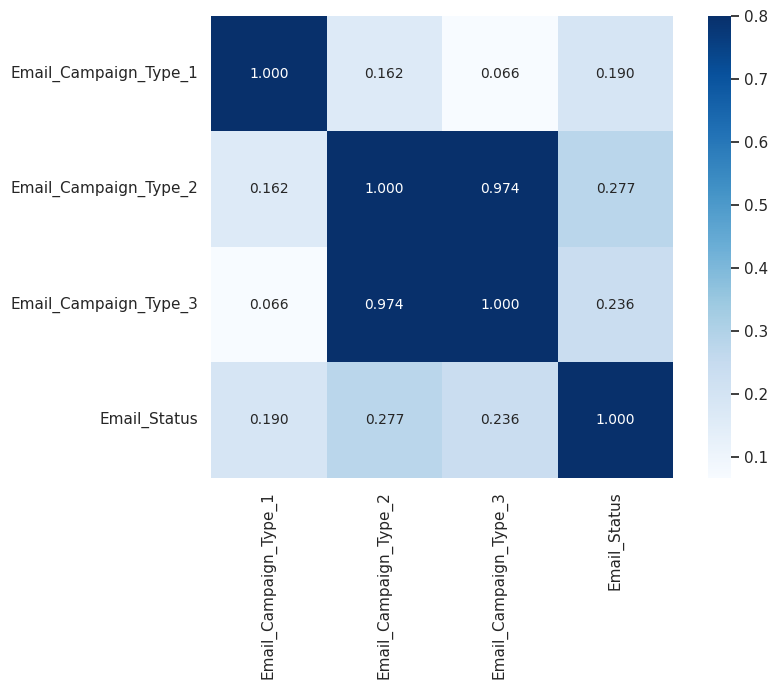

In [57]:
cat_corr_data=df.loc[:,['Email_Campaign_Type_1', 'Email_Campaign_Type_2', 
                               'Email_Campaign_Type_3', 'Email_Status']].corr().abs()
plt.figure(figsize=(9,6))
sns.heatmap(cat_corr_data, annot = True, fmt='.3f', annot_kws={'size': 10},  
            vmax=.8, square=True, cmap="Blues");                          

Email_Campaign_Type_1 has the lowest corelation with Email Status so lets remove them

In [58]:
# Dropping encoded features
df.drop(['Email_Type_2', 'Email_Source_Type_2', 'Email_Campaign_Type_1'], axis=1, inplace=True)

# Modelling

### Train Test Split

Lets assign independent and dependent feature to different variables

In [59]:
# x is independent variables and y is depenedent variable
X=df.drop('Email_Status',axis=True)
y=df['Email_Status']

As usual lets spliting train and test data with the ratio of 75:25 respectively 


In [60]:
# Spliting the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(50759, 8)
(16920, 8)


### Feature Scaling

It is important that features must be in a simailar scale to get a better result from most of the algorithms 

So lets scale the test and train data of the independent variable using standardization

In [61]:
# Standardization of independent variable
scaling=StandardScaler()
X_train=scaling.fit_transform(X_train)
X_test=scaling.transform(X_test)

## Handling Data Imbalance

We are already aware that our data set is highly imbalanced so it is very important to balance the traing data, else our model will get completely biased.

Lets use undersampling and oversampling (SMOTE) techniques for handling the data imbalance

In [62]:
# Undersampling Training data set
us = RandomUnderSampler(replacement=True)
X_train_us, y_train_us = us.fit_resample(X_train, y_train)

In [63]:
# Oversampling Training data set
smote=SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

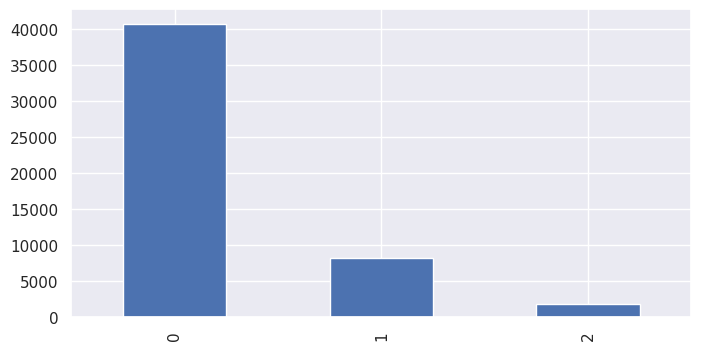

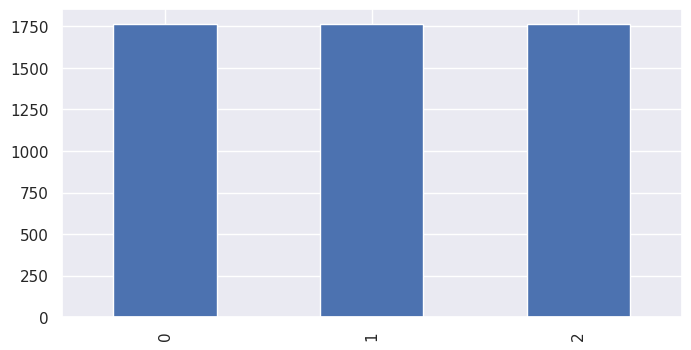

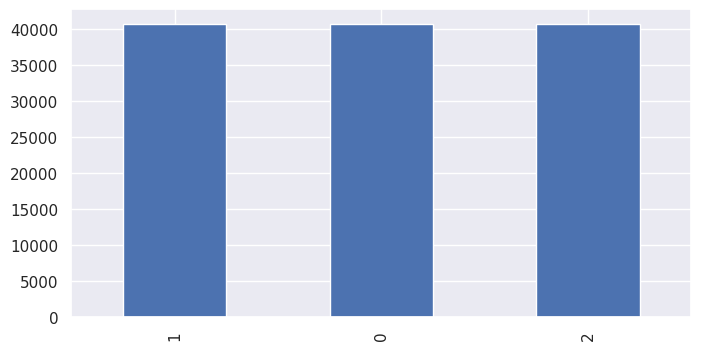

In [64]:
Columns=[y_train,y_train_us,y_train_smote]
for data in Columns:
  data.value_counts().plot(kind='bar')
  plt.show()

Created a balance dataset.Undersampled data has number of samples equal to the smallest original class whereas each class in oversampled data has number of samples equal to the largest original class.

Lets create a dataframe to store all calculated model metrics.

In [65]:
# Dataframe to store evaluation metrics of each model
metrics_table = pd.DataFrame(columns=['Model', 'Sampling', 'Train_Accuracy',
                                      'Test_Accuracy', 'Train_Precision', 'Test_Precision', 
                                      'Train_Recall', 'Test_Recall', 'Train_F1Score', 'Test_F1Score', 
                                      'Train_ROC_AUC', 'Test_ROC_AUC'])

In [66]:
metrics_table

,Model,Sampling,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1Score,Test_F1Score,Train_ROC_AUC,Test_ROC_AUC


## Decision Tree model with Hyper Parameter Tuning


In [67]:
# Initializing hyperparameters for decision tree classifier
decision_tree = DecisionTreeClassifier()
parameters = {'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10],
              'max_leaf_nodes': [5, 20, 100],
              'max_features': ['auto', 'sqrt', 'log2']} 

The best parameter
min_samples_split=5
min_samples_leaf=1
max_leaf_nodes=20
max_features=sqrt
max_depth=5

Best score: 0.5240793201133144

Training Data
Accuracy  : 53.918791 %
Precision : 52.848675 %
Recall    : 53.918791 %
F1 Score  : 52.380687 %
ROC AUC   : 0.705499

Testing Data
Accuracy  : 56.755319 %
Precision : 77.684841 %
Recall    : 56.755319 %
F1 Score  : 64.016439 %
ROC AUC   : 0.73218



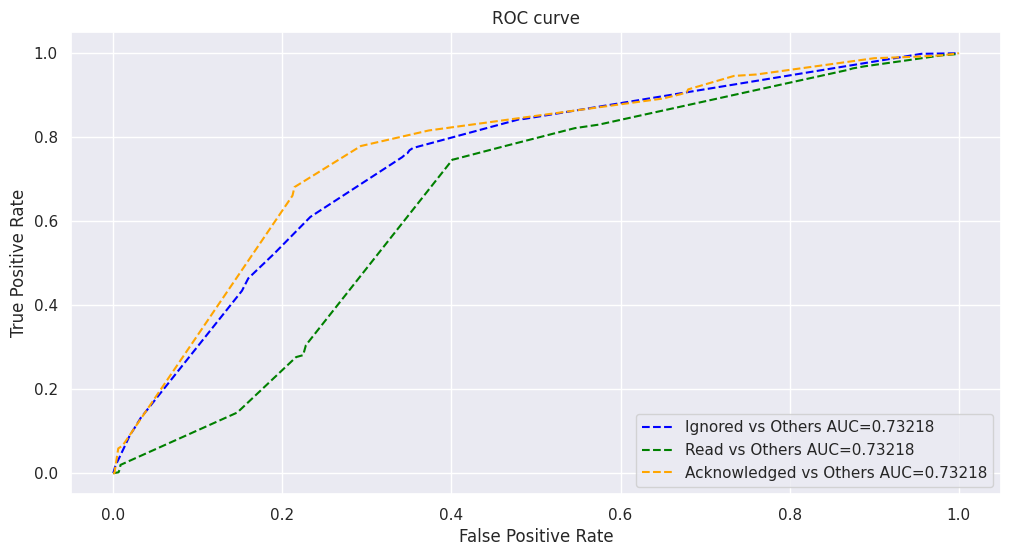

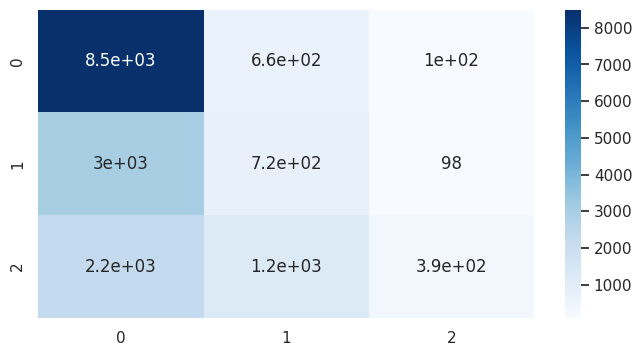

In [68]:
# Training the data with decision tree on random undersampling
dt_rus = RandomizedSearchCV(decision_tree, parameters, cv=5, n_iter=10)
dt_rus.fit(X_train_us, y_train_us)

# model evaluation
model_eval = cal_model_metrics(dt_rus, X_train_us, y_train_us, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Decision Tree', 'RandomUnderSampling', 
                                                model_eval['Train_Accuracy'], model_eval['Train_Precision'], 
                                                model_eval['Train_Recall'], model_eval['Train_F1_Score'], 
                                                model_eval['Train_ROC_AUC'], model_eval['Test_Accuracy'], 
                                                model_eval['Test_Precision'], model_eval['Test_Recall'], 
                                                model_eval['Test_F1_Score'], model_eval['Test_ROC_AUC']]



The best parameter
min_samples_split=2
min_samples_leaf=1
max_leaf_nodes=100
max_features=log2
max_depth=10

Best score: 0.5727372385297256

Training Data
Accuracy  : 57.737482 %
Precision : 56.807406 %
Recall    : 57.737482 %
F1 Score  : 56.16846 %
ROC AUC   : 0.761032

Testing Data
Accuracy  : 64.231678 %
Precision : 78.547659 %
Recall    : 64.231678 %
F1 Score  : 69.742954 %
ROC AUC   : 0.752606



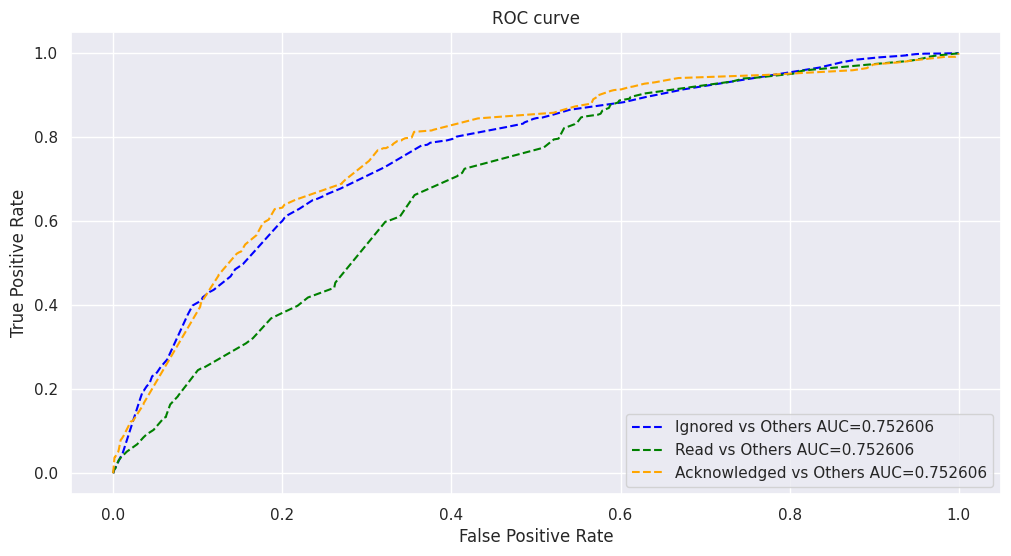

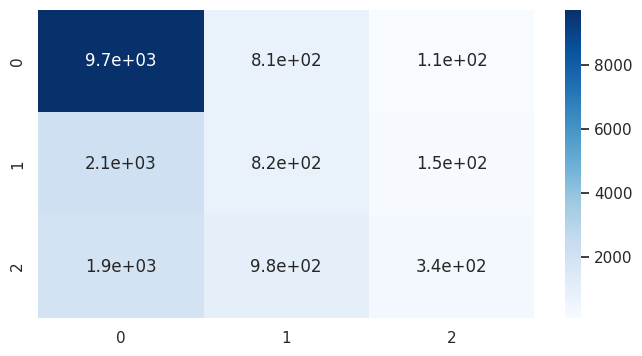

In [69]:
# Training data with decision tree on SMOTE
dt_smote = RandomizedSearchCV(decision_tree, parameters, cv=5, n_iter=10)
dt_smote.fit(X_train_smote, y_train_smote)

# model evaluation
model_evaluation = cal_model_metrics(dt_smote, X_train_smote, y_train_smote, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Decision Tree', 'SMOTE', 
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'], 
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'], 
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'], 
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'], 
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

## XGBoost with Hyper Parameter Tuning 


In [71]:
# Initializing hyperparameters for XGBoost classifier
xgboost = xgb.XGBClassifier(objective='multi:softmax', verbosity=0)
parameters = {'max_depth': [2, 5, 10],
              'learning_rate': [0.05, 0.1, 0.2],
              'min_child_weight': [1, 2, 5],
              'gamma': [0, 0.1, 0.3],
              'colsample_bytree': [0.3, 0.5, 0.7]}

The best parameter
min_child_weight=2
max_depth=5
learning_rate=0.05
gamma=0
colsample_bytree=0.7

Best score: 0.5474976392823419

Training Data
Accuracy  : 61.057602 %
Precision : 60.951333 %
Recall    : 61.057602 %
F1 Score  : 59.731638 %
ROC AUC   : 0.80272

Testing Data
Accuracy  : 62.771868 %
Precision : 78.269658 %
Recall    : 62.771868 %
F1 Score  : 68.652267 %
ROC AUC   : 0.767883



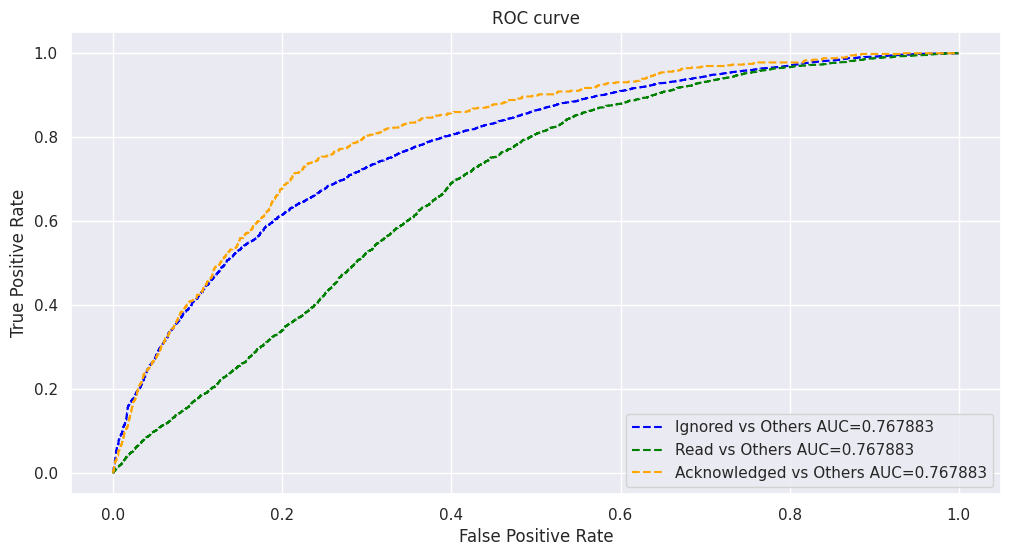

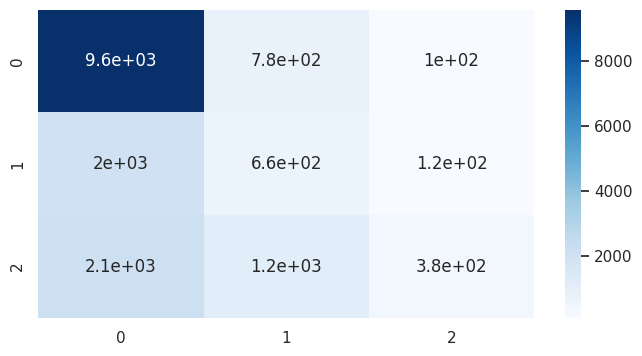

In [72]:
# train data with XGBoost on random undersampling
xgb_rus = RandomizedSearchCV(xgboost, parameters, cv=5, n_iter=10)
xgb_rus.fit(X_train_us, y_train_us)

# model evaluation
model_evaluation = cal_model_metrics(xgb_rus, X_train_us, y_train_us, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['XGBoost', 'RandomUnderSampling', 
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'], 
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'], 
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'], 
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'], 
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

The best parameter
min_child_weight=5
max_depth=10
learning_rate=0.2
gamma=0.3
colsample_bytree=0.7

Best score: 0.798474968311899

Training Data
Accuracy  : 88.172122 %
Precision : 88.37317 %
Recall    : 88.172122 %
F1 Score  : 87.927865 %
ROC AUC   : 0.969892

Testing Data
Accuracy  : 80.425532 %
Precision : 76.36006 %
Recall    : 80.425532 %
F1 Score  : 77.77004 %
ROC AUC   : 0.772655



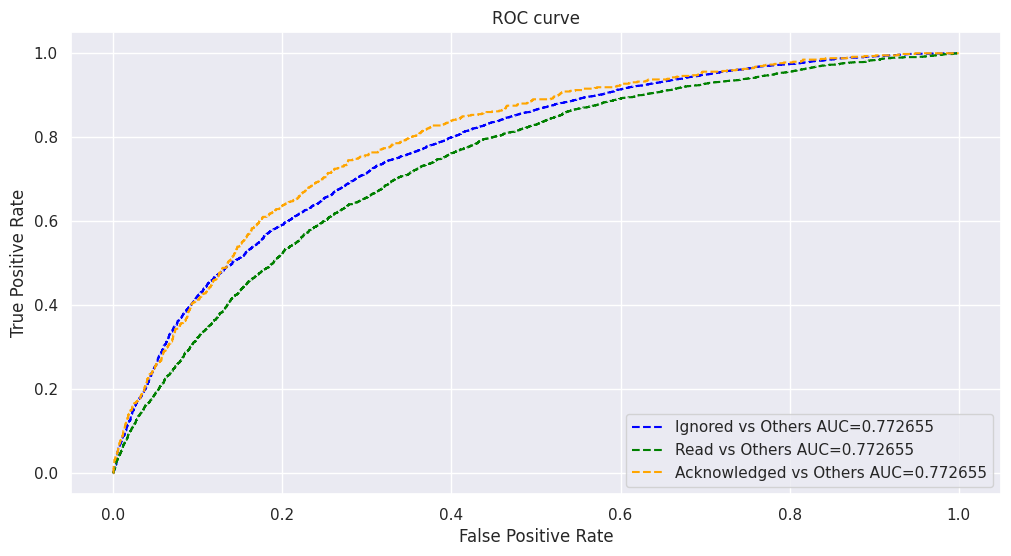

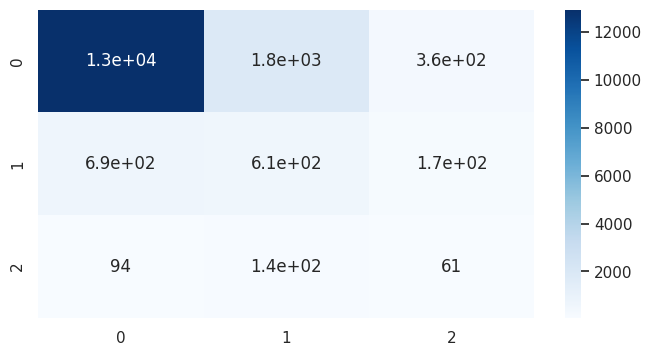

In [74]:
# Training data with XGBoost on SMOTE
xgb_smote = RandomizedSearchCV(xgboost, parameters, cv=5, n_iter=10)
xgb_smote.fit(X_train_smote, y_train_smote)

# model evaluation
model_evaluation = cal_model_metrics(xgb_smote, X_train_smote, y_train_smote, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['XGBoost', 'SMOTE', 
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'], 
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'], 
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'], 
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'], 
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

## KNN with Hyper Parameter Tuning

In [76]:
# Initializing hyperparameters for KNN classifier
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[5, 10, 15],
              'weights':['uniform','distance'],
              'metric':['minkowski','euclidean','manhattan'],
              'leaf_size':[10, 20, 30]}

The best parameter
weights=distance
n_neighbors=15
metric=minkowski
leaf_size=30

Best score: 0.5418319169027385

Training Data
Accuracy  : 99.848914 %
Precision : 99.849224 %
Recall    : 99.848914 %
F1 Score  : 99.848871 %
ROC AUC   : 0.999997

Testing Data
Accuracy  : 57.677305 %
Precision : 77.917086 %
Recall    : 57.677305 %
F1 Score  : 64.77351 %
ROC AUC   : 0.736438



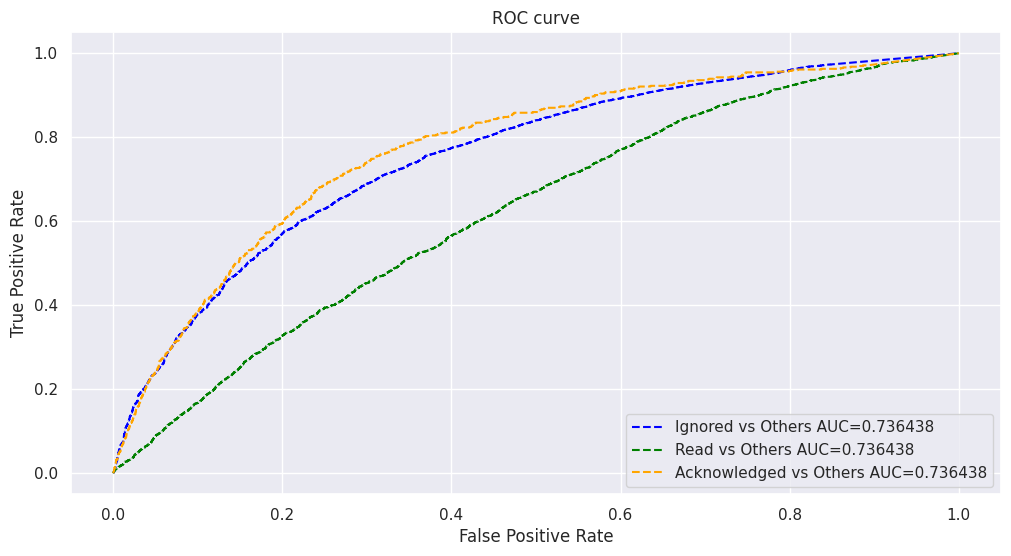

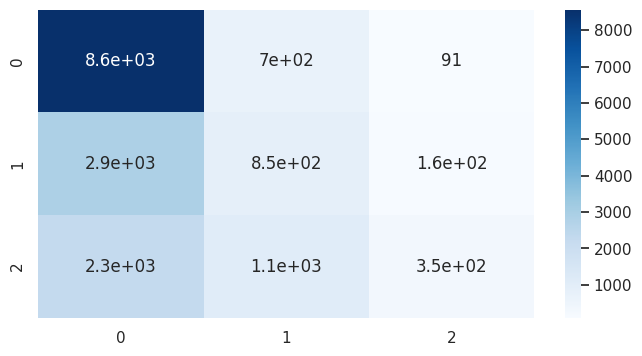

In [77]:
# Training data with KNN on random undersampling
knn_rus = RandomizedSearchCV(knn, parameters, cv=5, n_iter=10)
knn_rus.fit(X_train_us, y_train_us)

# model evaluation
model_evaluation = cal_model_metrics(knn_rus, X_train_us, y_train_us, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['KNN', 'RandomUnderSampling', 
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'], 
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'], 
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'], 
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'], 
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

The best parameter
weights=distance
n_neighbors=5
metric=manhattan
leaf_size=30

Best score: 0.852129046819396

Training Data
Accuracy  : 99.856865 %
Precision : 99.857236 %
Recall    : 99.856865 %
F1 Score  : 99.856889 %
ROC AUC   : 0.999998

Testing Data
Accuracy  : 63.037825 %
Precision : 75.137169 %
Recall    : 63.037825 %
F1 Score  : 67.802226 %
ROC AUC   : 0.677275



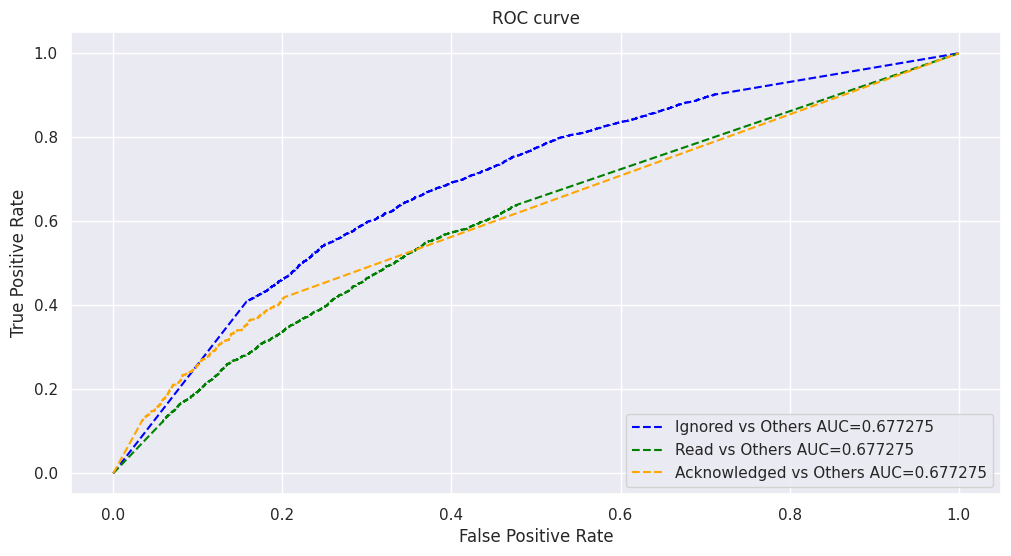

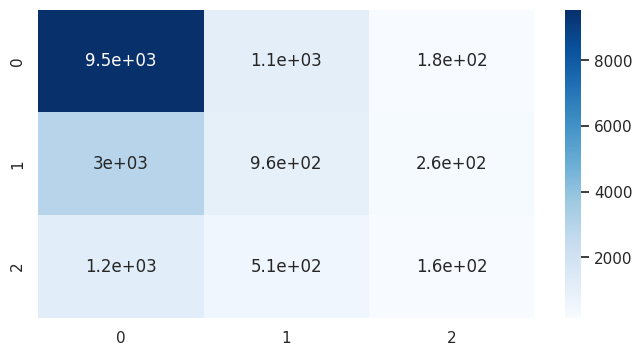

In [79]:
# Training data with KNN on SMOTE
knn_smote = RandomizedSearchCV(knn, parameters, cv=5, n_iter=10)
knn_smote.fit(X_train_smote, y_train_smote)

# model evaluation
model_evaluation = cal_model_metrics(knn_smote, X_train_smote, y_train_smote, X_test, y_test)

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['KNN', 'SMOTE', 
                                                model_evaluation['Train_Accuracy'], model_evaluation['Train_Precision'], 
                                                model_evaluation['Train_Recall'], model_evaluation['Train_F1_Score'], 
                                                model_evaluation['Train_ROC_AUC'], model_evaluation['Test_Accuracy'], 
                                                model_evaluation['Test_Precision'], model_evaluation['Test_Recall'], 
                                                model_evaluation['Test_F1_Score'], model_evaluation['Test_ROC_AUC']]

In [80]:
metrics_table

,Model,Sampling,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1Score,Test_F1Score,Train_ROC_AUC,Test_ROC_AUC
0,Decision Tree,RandomUnderSampling,53.918791,52.848675,53.918791,52.380687,0.705499,56.755319,77.684841,56.755319,64.016439,0.732180
1,Decision Tree,SMOTE,57.737482,56.807406,57.737482,56.168460,0.761032,64.231678,78.547659,64.231678,69.742954,0.752606
2,XGBoost,RandomUnderSampling,61.057602,60.951333,61.057602,59.731638,0.802720,62.771868,78.269658,62.771868,68.652267,0.767883
3,XGBoost,SMOTE,88.172122,88.373170,88.172122,87.927865,0.969892,80.425532,76.360060,80.425532,77.770040,0.772655
4,KNN,RandomUnderSampling,99.848914,99.849224,99.848914,99.848871,0.999997,57.677305,77.917086,57.677305,64.773510,0.736438
5,KNN,SMOTE,99.856865,99.857236,99.856865,99.856889,0.999998,63.037825,75.137169,63.037825,67.802226,0.677275


We cannot use accuracy, precision, recall or ROC-AUC to compare the performance of models since the data is imbalanced. So we are using F1 score to compare different models and find out which one is better. Higher the F1 score, better the model.

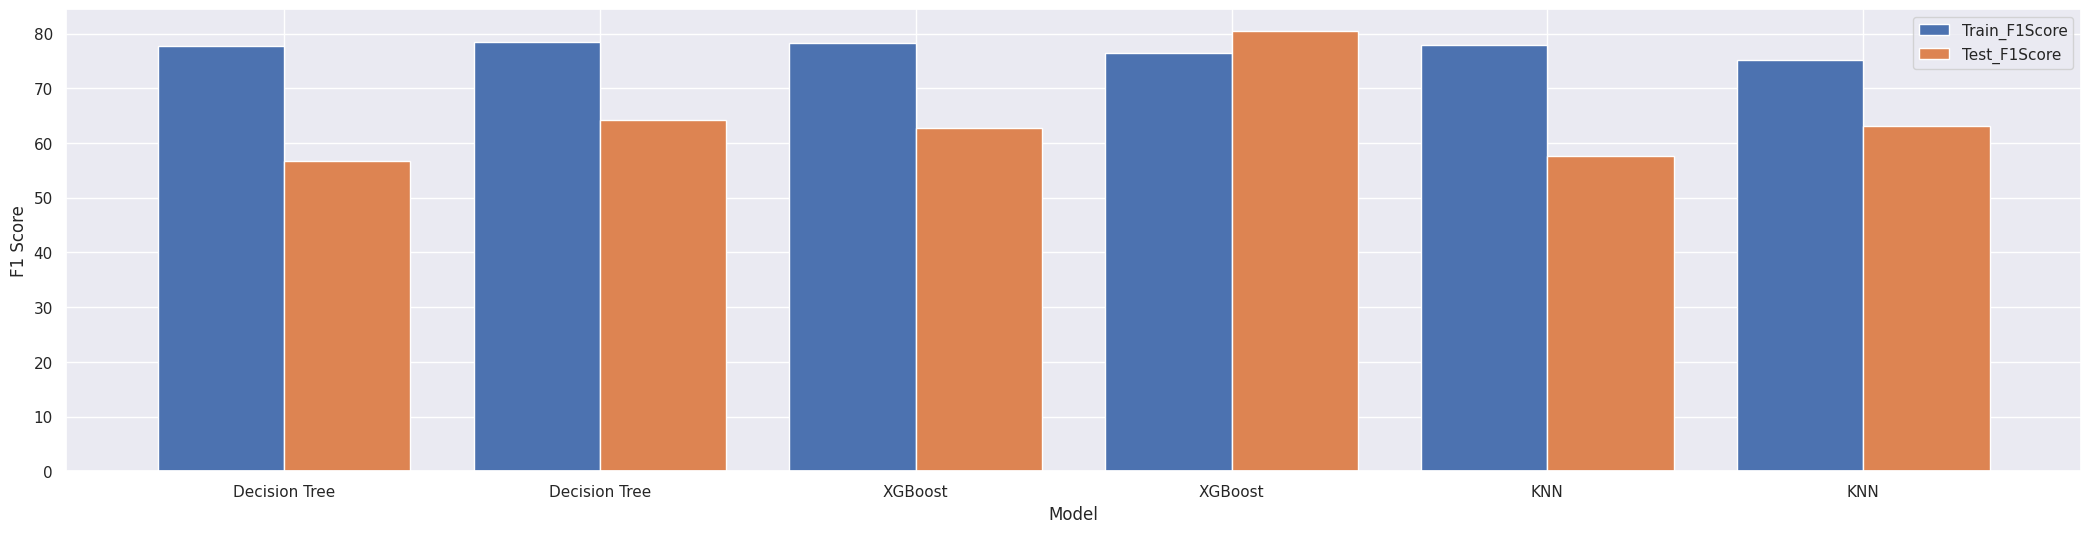

In [98]:
# Graph to visualize F1 score of each model
plt.figure(figsize=(26, 6))

X = metrics_table['Model'].tolist()
Y = metrics_table['Train_F1Score'].tolist()
Z = metrics_table['Test_F1Score'].tolist()
    
X_axis_length = np.arange(len(X))
    
plt.bar(X_axis_length - 0.2, Y, 0.4, label ='Train_F1Score')
plt.bar(X_axis_length + 0.2, Z, 0.4, label = 'Test_F1Score')

plt.xticks(X_axis_length, X)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

We can choose the model built using XGBoost algorithm with SMOTE dataset as it has the highest F1 score and also all other models tends to overfit.

# Conclusion

## Conclusion from EDA


1.Less number of e-mails of campaign type 1 got ignored.

2.Customer location or time of day does not affect the status of e-mail.
3.As the number of previous communication increases, the chances of the e-mail being read or acknowledged also increases.

4.E-mails tend to get ignored when word count is greater than 800.

## Recommendations

1.Campaign 1 is more successful than other campaigns. So it is wise to continue Campaign 1 and discontinue others.

2.Limit word count to less than 800.

## Insights from modelling

The model built using XGBoost algorithm with SMOTE dataset performed better than the other models. It can be preferred for predicting mail statuses.

Oversampled data seems to be better than undersampled data. This can be due to the fact that undersampling causes loss of information.